# Part 10.4: Image Captioning with Keras and TensorFlow

Image captioning is a new technology that combines LSTM text generation with the computer vision powers of a convolutional neural network.  I first saw this technology in [Andrej Karpathy's Dissertation](https://cs.stanford.edu/people/karpathy/main.pdf). Images from his work are shown here:

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/karpathy_thesis.jpg "Captioning")

In this part, we will make use of LSTM and CNN to create a basic image captioning system. Transfer learning will be used to bring in these two projects:

* [InceptionV3](https://arxiv.org/abs/1512.00567)
* [Glove](https://nlp.stanford.edu/projects/glove/)

Inception is used to extract features from the images.  Glove is a set of Natural Language Processing (NLP) vectors for common words.

The following diagram gives a high-level overview of captioning.

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-1.png "Captioning")

We begin by importing the needed libraries.

In [1]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 5
USE_INCEPTION = True

C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

The following function is used to nicely format elapsed times.

In [2]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

### Needed Data

You will need to download the following data and place it in a folder for this example.  Point the *root_captioning* string at the folder that you are using for the caption generation. This folder should have the following sub-folders.

* data - Create this directory to hold saved models.
* [glove.6B](https://nlp.stanford.edu/projects/glove/) - Glove embeddings.
* [Flicker8k_Dataset](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip) - Flicker dataset.
* [Flicker8k_Text](https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip)

Note, the original Flickr datasets are no longer available, but can be downloaded from [this article](https://machinelearningmastery.com/prepare-photo-caption-dataset-training-deep-learning-model/). 


### Google CoLab

If you are using Google CoLab then you will need to execute this cell.

In [5]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()
root_captioning = "flickr8k\Flickr_Data\Flickr_Data"

with open( os.path.join(root_captioning,'Flickr_TextData','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]  #lowercase all words
      desc = [w.translate(null_punct) for w in desc] # remove punctuations
      desc = [word for word in desc if len(word)>1] #remove small words
      desc = [word for word in desc if word.isalpha()]  #remove all digits
      max_length = max(max_length,len(desc)) #calculate the max length of the caption
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


Stats on what was collected.

In [6]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


Load the Glove embeddings.

In [7]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Images', '*.jpg'))

Display the count of how many Glove embeddings we have.

In [8]:
len(img)

8091

Read all image names and use the predefined train/test sets.

In [9]:
train_images_path = os.path.join(root_captioning,'Flickr_TextData','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr_TextData','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [10]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [11]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [12]:
len(train_descriptions)

6000

### Choosing a Computer Vision Neural Network to Transfer

There are two neural networks that are accessed via transfer learning.  In this example, I use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowldge transferred in, this example would take consideraby more training.

I made it so you can interchange the neural network used for the images.  By setting the values WIDTH, HEIGHT, and OUTPUT_DIM you can interchange images.  One characteristic that you are seeking for the image neural network is that it does not have too many outputs (once you strip the 1000-class imagenet classifier, as is common in transfer learning).  InceptionV3 has 2,048 features below the classifier and MobileNet has over 50K.  If the additional dimensions truely capture aspects of the images, then they are worthwhile.  However, having 50K features increases the processing needed and the complexity of the neural network we are constructing.

In [13]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

Instructions for updating:
Colocations handled automatically by placer.


The summary for the chosen image neural network to be transfered is displayed.

In [14]:
encode_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 35, 35, 256)  0           activation_5[0][0]               
                                                                 activation_7[0][0]               
                                                                 activation_10[0][0]              
                                                                 activation_11[0][0]              
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_15 (Batc (None, 35, 35, 64)   192         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_v1_19 (Batc (None, 35, 35, 64)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_21 (Batc (None, 35, 35, 64)   192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_24 (Batc (None, 35, 35, 96)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_25 (Batc (None, 35, 35, 64)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 35, 35, 64)   0           batch_normalization_v1_19[0][0]  
__________

batch_normalization_v1_37 (Batc (None, 17, 17, 128)  384         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 17, 17, 128)  0           batch_normalization_v1_32[0][0]  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 17, 17, 128)  0           batch_normalization_v1_37[0][0]  
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 

__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 17, 17, 192)  576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_43 (Batc (None, 17, 17, 192)  576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 17, 17, 192)  576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_49 (Batc (None, 17, 17, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 17, 17, 192)  0           batch_normalization_v1_40[0][0]  
__________

activation_59 (Activation)      (None, 17, 17, 192)  0           batch_normalization_v1_59[0][0]  
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 17, 17, 768)  0           activation_50[0][0]              
                                                                 activation_53[0][0]              
                                                                 activation_58[0][0]              
                                                                 activation_59[0][0]              
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_64 (Batc (None, 17, 17, 192)  576         conv2d_64[0][0]                  
__________

batch_normalization_v1_73 (Batc (None, 17, 17, 192)  576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 17, 17, 192)  0           batch_normalization_v1_73[0][0]  
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 17, 17, 192)  258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_70 (Batc (None, 17, 17, 192)  576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_83 (Activation)      (None, 8, 8, 384)    0           batch_normalization_v1_83[0][0]  
__________________________________________________________________________________________________
batch_normalization_v1_84 (Batc (None, 8, 8, 192)    576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 8, 8, 320)    0           batch_normalization_v1_76[0][0]  
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 8, 8, 768)    0           activation_78[0][0]              
                                                                 activation_79[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 768)    0           activation_82[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 2048)         0           mixed10[0][0]                    
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [15]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.

  x = np.reshape(x, x.shape[1] )
  return x

We can how generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.

In [16]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

A similar process must also be performed for the test images.

In [17]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

Next we separate the captions that will be usef for training.  There are two sides to this training, the images and the captions.

In [18]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [19]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [20]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [21]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Up to this point we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to generate all of the training data ahead of time.  The memory demands can be considerable.  If the training data can be generated, as the neural network needs it, it is possable to use a Keras generator.  The generator will create new data, as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

If we were to build all needed training data ahead of time it would look something like below.

![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-2.png "Captioning")

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have.  Additionally the Flikr8K data set has 5 captions for each picture.  Those would all require duplication of data as well.  It is much more efficient to just generate the data as needed.

In [22]:
from tensorflow.keras.preprocessing import sequence
def data_generator2(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [23]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:22, 17622.44it/s]


Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [24]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector


The matrix makes sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [25]:
embedding_matrix.shape

(1652, 200)

In [26]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
embedding_dim

200

In [28]:
caption_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [29]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [30]:
number_pics_per_bath = 3
steps = len(train_descriptions)/number_pics_per_bath

In [31]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
start= time()
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS)):
      steps= int(steps)
      generator = data_generator2(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator2(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


 314/2000 [===>..........................] - ETA: 52:51 - loss: 7.42 - ETA: 31:51 - loss: 7.27 - ETA: 25:16 - loss: 7.14 - ETA: 21:31 - loss: 6.98 - ETA: 19:20 - loss: 6.85 - ETA: 17:53 - loss: 6.74 - ETA: 16:45 - loss: 6.65 - ETA: 16:03 - loss: 6.50 - ETA: 15:31 - loss: 6.43 - ETA: 15:03 - loss: 6.50 - ETA: 14:37 - loss: 6.48 - ETA: 14:11 - loss: 6.47 - ETA: 13:52 - loss: 6.43 - ETA: 13:32 - loss: 6.38 - ETA: 13:21 - loss: 6.34 - ETA: 13:08 - loss: 6.32 - ETA: 12:57 - loss: 6.28 - ETA: 12:47 - loss: 6.25 - ETA: 12:36 - loss: 6.21 - ETA: 12:28 - loss: 6.19 - ETA: 12:20 - loss: 6.18 - ETA: 12:12 - loss: 6.16 - ETA: 12:07 - loss: 6.12 - ETA: 12:01 - loss: 6.10 - ETA: 11:55 - loss: 6.09 - ETA: 11:50 - loss: 6.07 - ETA: 11:44 - loss: 6.06 - ETA: 11:40 - loss: 6.03 - ETA: 11:35 - loss: 6.00 - ETA: 11:31 - loss: 5.97 - ETA: 11:27 - loss: 5.94 - ETA: 11:25 - loss: 5.95 - ETA: 11:24 - loss: 5.94 - ETA: 11:24 - loss: 5.92 - ETA: 11:22 - loss: 5.92 - ETA: 11:19 - loss: 5.92 - ETA: 11:16 - loss: 

 628/2000 [========>.....................] - ETA: 8:52 - loss: 5.013 - ETA: 8:52 - loss: 5.011 - ETA: 8:52 - loss: 5.008 - ETA: 8:51 - loss: 5.005 - ETA: 8:51 - loss: 5.005 - ETA: 8:51 - loss: 5.002 - ETA: 8:50 - loss: 5.002 - ETA: 8:50 - loss: 5.001 - ETA: 8:50 - loss: 4.999 - ETA: 8:49 - loss: 4.999 - ETA: 8:49 - loss: 4.996 - ETA: 8:49 - loss: 4.996 - ETA: 8:48 - loss: 4.996 - ETA: 8:48 - loss: 4.994 - ETA: 8:47 - loss: 4.992 - ETA: 8:47 - loss: 4.989 - ETA: 8:47 - loss: 4.987 - ETA: 8:46 - loss: 4.986 - ETA: 8:46 - loss: 4.985 - ETA: 8:46 - loss: 4.982 - ETA: 8:45 - loss: 4.981 - ETA: 8:45 - loss: 4.978 - ETA: 8:45 - loss: 4.976 - ETA: 8:44 - loss: 4.973 - ETA: 8:44 - loss: 4.970 - ETA: 8:43 - loss: 4.969 - ETA: 8:43 - loss: 4.968 - ETA: 8:43 - loss: 4.967 - ETA: 8:42 - loss: 4.965 - ETA: 8:42 - loss: 4.963 - ETA: 8:41 - loss: 4.960 - ETA: 8:41 - loss: 4.956 - ETA: 8:41 - loss: 4.956 - ETA: 8:40 - loss: 4.956 - ETA: 8:40 - loss: 4.954 - ETA: 8:40 - loss: 4.952 - ETA: 8:39 - loss: 4

 942/2000 [=============>................] - ETA: 7:07 - loss: 4.636 - ETA: 7:07 - loss: 4.635 - ETA: 7:07 - loss: 4.635 - ETA: 7:07 - loss: 4.635 - ETA: 7:06 - loss: 4.633 - ETA: 7:06 - loss: 4.633 - ETA: 7:06 - loss: 4.632 - ETA: 7:05 - loss: 4.632 - ETA: 7:05 - loss: 4.631 - ETA: 7:05 - loss: 4.630 - ETA: 7:04 - loss: 4.629 - ETA: 7:04 - loss: 4.628 - ETA: 7:04 - loss: 4.626 - ETA: 7:03 - loss: 4.626 - ETA: 7:03 - loss: 4.625 - ETA: 7:03 - loss: 4.623 - ETA: 7:02 - loss: 4.623 - ETA: 7:02 - loss: 4.622 - ETA: 7:02 - loss: 4.621 - ETA: 7:01 - loss: 4.620 - ETA: 7:01 - loss: 4.619 - ETA: 7:01 - loss: 4.619 - ETA: 7:00 - loss: 4.618 - ETA: 7:00 - loss: 4.619 - ETA: 7:00 - loss: 4.618 - ETA: 7:00 - loss: 4.618 - ETA: 6:59 - loss: 4.617 - ETA: 6:59 - loss: 4.616 - ETA: 6:59 - loss: 4.615 - ETA: 6:58 - loss: 4.615 - ETA: 6:58 - loss: 4.614 - ETA: 6:58 - loss: 4.614 - ETA: 6:57 - loss: 4.614 - ETA: 6:57 - loss: 4.613 - ETA: 6:57 - loss: 4.612 - ETA: 6:56 - loss: 4.611 - ETA: 6:56 - loss: 4

1256/2000 [=================>............] - ETA: 5:28 - loss: 4.461 - ETA: 5:28 - loss: 4.461 - ETA: 5:28 - loss: 4.460 - ETA: 5:28 - loss: 4.460 - ETA: 5:27 - loss: 4.460 - ETA: 5:27 - loss: 4.459 - ETA: 5:27 - loss: 4.459 - ETA: 5:26 - loss: 4.459 - ETA: 5:26 - loss: 4.459 - ETA: 5:26 - loss: 4.460 - ETA: 5:25 - loss: 4.460 - ETA: 5:25 - loss: 4.459 - ETA: 5:25 - loss: 4.460 - ETA: 5:24 - loss: 4.459 - ETA: 5:24 - loss: 4.459 - ETA: 5:24 - loss: 4.458 - ETA: 5:24 - loss: 4.458 - ETA: 5:23 - loss: 4.458 - ETA: 5:23 - loss: 4.457 - ETA: 5:23 - loss: 4.456 - ETA: 5:23 - loss: 4.457 - ETA: 5:22 - loss: 4.456 - ETA: 5:22 - loss: 4.456 - ETA: 5:22 - loss: 4.455 - ETA: 5:22 - loss: 4.454 - ETA: 5:21 - loss: 4.454 - ETA: 5:21 - loss: 4.453 - ETA: 5:21 - loss: 4.452 - ETA: 5:21 - loss: 4.451 - ETA: 5:20 - loss: 4.451 - ETA: 5:20 - loss: 4.451 - ETA: 5:20 - loss: 4.451 - ETA: 5:19 - loss: 4.450 - ETA: 5:19 - loss: 4.450 - ETA: 5:19 - loss: 4.449 - ETA: 5:19 - loss: 4.449 - ETA: 5:19 - loss: 4

1570/2000 [======================>.......] - ETA: 3:51 - loss: 4.340 - ETA: 3:51 - loss: 4.339 - ETA: 3:51 - loss: 4.339 - ETA: 3:50 - loss: 4.338 - ETA: 3:50 - loss: 4.338 - ETA: 3:50 - loss: 4.338 - ETA: 3:49 - loss: 4.337 - ETA: 3:49 - loss: 4.336 - ETA: 3:49 - loss: 4.335 - ETA: 3:49 - loss: 4.335 - ETA: 3:48 - loss: 4.334 - ETA: 3:48 - loss: 4.334 - ETA: 3:48 - loss: 4.334 - ETA: 3:47 - loss: 4.333 - ETA: 3:47 - loss: 4.333 - ETA: 3:47 - loss: 4.333 - ETA: 3:46 - loss: 4.332 - ETA: 3:46 - loss: 4.332 - ETA: 3:46 - loss: 4.332 - ETA: 3:45 - loss: 4.331 - ETA: 3:45 - loss: 4.331 - ETA: 3:45 - loss: 4.330 - ETA: 3:44 - loss: 4.330 - ETA: 3:44 - loss: 4.330 - ETA: 3:44 - loss: 4.329 - ETA: 3:43 - loss: 4.329 - ETA: 3:43 - loss: 4.329 - ETA: 3:43 - loss: 4.329 - ETA: 3:43 - loss: 4.328 - ETA: 3:42 - loss: 4.328 - ETA: 3:42 - loss: 4.328 - ETA: 3:42 - loss: 4.328 - ETA: 3:41 - loss: 4.328 - ETA: 3:41 - loss: 4.328 - ETA: 3:41 - loss: 4.327 - ETA: 3:40 - loss: 4.327 - ETA: 3:40 - loss: 4

1890/2000 [===========================>..] - ETA: 2:13 - loss: 4.232 - ETA: 2:13 - loss: 4.231 - ETA: 2:12 - loss: 4.231 - ETA: 2:12 - loss: 4.231 - ETA: 2:12 - loss: 4.231 - ETA: 2:11 - loss: 4.231 - ETA: 2:11 - loss: 4.231 - ETA: 2:11 - loss: 4.231 - ETA: 2:10 - loss: 4.230 - ETA: 2:10 - loss: 4.230 - ETA: 2:10 - loss: 4.229 - ETA: 2:09 - loss: 4.230 - ETA: 2:09 - loss: 4.229 - ETA: 2:09 - loss: 4.229 - ETA: 2:09 - loss: 4.228 - ETA: 2:08 - loss: 4.228 - ETA: 2:08 - loss: 4.228 - ETA: 2:08 - loss: 4.228 - ETA: 2:07 - loss: 4.228 - ETA: 2:07 - loss: 4.227 - ETA: 2:07 - loss: 4.227 - ETA: 2:06 - loss: 4.226 - ETA: 2:06 - loss: 4.226 - ETA: 2:06 - loss: 4.226 - ETA: 2:05 - loss: 4.225 - ETA: 2:05 - loss: 4.225 - ETA: 2:05 - loss: 4.225 - ETA: 2:04 - loss: 4.225 - ETA: 2:04 - loss: 4.225 - ETA: 2:04 - loss: 4.225 - ETA: 2:04 - loss: 4.224 - ETA: 2:03 - loss: 4.224 - ETA: 2:03 - loss: 4.224 - ETA: 2:03 - loss: 4.223 - ETA: 2:02 - loss: 4.223 - ETA: 2:02 - loss: 4.222 - ETA: 2:02 - loss: 4

2000/2000 [==============================] - ETA: 33s - loss: 4.14 - ETA: 33s - loss: 4.14 - ETA: 33s - loss: 4.14 - ETA: 32s - loss: 4.14 - ETA: 32s - loss: 4.14 - ETA: 32s - loss: 4.14 - ETA: 31s - loss: 4.14 - ETA: 31s - loss: 4.14 - ETA: 31s - loss: 4.14 - ETA: 31s - loss: 4.14 - ETA: 30s - loss: 4.14 - ETA: 30s - loss: 4.14 - ETA: 30s - loss: 4.14 - ETA: 29s - loss: 4.14 - ETA: 29s - loss: 4.14 - ETA: 29s - loss: 4.14 - ETA: 28s - loss: 4.14 - ETA: 28s - loss: 4.14 - ETA: 28s - loss: 4.13 - ETA: 27s - loss: 4.13 - ETA: 27s - loss: 4.13 - ETA: 27s - loss: 4.13 - ETA: 27s - loss: 4.13 - ETA: 26s - loss: 4.13 - ETA: 26s - loss: 4.13 - ETA: 26s - loss: 4.13 - ETA: 25s - loss: 4.13 - ETA: 25s - loss: 4.13 - ETA: 25s - loss: 4.13 - ETA: 24s - loss: 4.13 - ETA: 24s - loss: 4.13 - ETA: 24s - loss: 4.13 - ETA: 23s - loss: 4.13 - ETA: 23s - loss: 4.13 - ETA: 23s - loss: 4.13 - ETA: 22s - loss: 4.13 - ETA: 22s - loss: 4.13 - ETA: 22s - loss: 4.13 - ETA: 22s - loss: 4.13 - ETA: 21s - loss: 4.

 20%|████████████████▌                                                                  | 1/5 [10:21<41:25, 621.47s/it]

 314/2000 [===>..........................] - ETA: 11:09 - loss: 3.57 - ETA: 10:47 - loss: 3.59 - ETA: 11:01 - loss: 3.45 - ETA: 10:45 - loss: 3.34 - ETA: 10:43 - loss: 3.34 - ETA: 10:37 - loss: 3.31 - ETA: 10:27 - loss: 3.36 - ETA: 10:28 - loss: 3.31 - ETA: 10:33 - loss: 3.34 - ETA: 10:36 - loss: 3.40 - ETA: 10:32 - loss: 3.42 - ETA: 10:26 - loss: 3.46 - ETA: 10:24 - loss: 3.46 - ETA: 10:19 - loss: 3.46 - ETA: 10:20 - loss: 3.44 - ETA: 10:17 - loss: 3.46 - ETA: 10:16 - loss: 3.48 - ETA: 10:17 - loss: 3.51 - ETA: 10:16 - loss: 3.48 - ETA: 10:15 - loss: 3.50 - ETA: 10:13 - loss: 3.53 - ETA: 10:11 - loss: 3.52 - ETA: 10:11 - loss: 3.49 - ETA: 10:09 - loss: 3.48 - ETA: 10:08 - loss: 3.50 - ETA: 10:06 - loss: 3.51 - ETA: 10:06 - loss: 3.53 - ETA: 10:06 - loss: 3.51 - ETA: 10:05 - loss: 3.51 - ETA: 10:03 - loss: 3.50 - ETA: 10:01 - loss: 3.46 - ETA: 10:02 - loss: 3.48 - ETA: 10:02 - loss: 3.48 - ETA: 10:04 - loss: 3.48 - ETA: 10:05 - loss: 3.50 - ETA: 10:05 - loss: 3.50 - ETA: 10:05 - loss: 

 628/2000 [========>.....................] - ETA: 8:41 - loss: 3.566 - ETA: 8:40 - loss: 3.566 - ETA: 8:40 - loss: 3.564 - ETA: 8:40 - loss: 3.562 - ETA: 8:39 - loss: 3.564 - ETA: 8:39 - loss: 3.562 - ETA: 8:39 - loss: 3.562 - ETA: 8:38 - loss: 3.564 - ETA: 8:38 - loss: 3.563 - ETA: 8:38 - loss: 3.564 - ETA: 8:37 - loss: 3.563 - ETA: 8:37 - loss: 3.565 - ETA: 8:37 - loss: 3.566 - ETA: 8:36 - loss: 3.566 - ETA: 8:36 - loss: 3.566 - ETA: 8:36 - loss: 3.564 - ETA: 8:35 - loss: 3.564 - ETA: 8:35 - loss: 3.564 - ETA: 8:35 - loss: 3.565 - ETA: 8:34 - loss: 3.563 - ETA: 8:34 - loss: 3.563 - ETA: 8:34 - loss: 3.562 - ETA: 8:34 - loss: 3.562 - ETA: 8:33 - loss: 3.560 - ETA: 8:33 - loss: 3.560 - ETA: 8:33 - loss: 3.559 - ETA: 8:32 - loss: 3.560 - ETA: 8:32 - loss: 3.561 - ETA: 8:32 - loss: 3.561 - ETA: 8:31 - loss: 3.560 - ETA: 8:31 - loss: 3.558 - ETA: 8:30 - loss: 3.556 - ETA: 8:30 - loss: 3.555 - ETA: 8:30 - loss: 3.557 - ETA: 8:29 - loss: 3.555 - ETA: 8:29 - loss: 3.555 - ETA: 8:29 - loss: 3

 942/2000 [=============>................] - ETA: 7:02 - loss: 3.487 - ETA: 7:02 - loss: 3.487 - ETA: 7:02 - loss: 3.488 - ETA: 7:02 - loss: 3.488 - ETA: 7:01 - loss: 3.487 - ETA: 7:01 - loss: 3.488 - ETA: 7:01 - loss: 3.487 - ETA: 7:00 - loss: 3.488 - ETA: 7:00 - loss: 3.488 - ETA: 7:00 - loss: 3.488 - ETA: 6:59 - loss: 3.488 - ETA: 6:59 - loss: 3.487 - ETA: 6:59 - loss: 3.487 - ETA: 6:58 - loss: 3.487 - ETA: 6:58 - loss: 3.487 - ETA: 6:58 - loss: 3.486 - ETA: 6:58 - loss: 3.486 - ETA: 6:57 - loss: 3.486 - ETA: 6:57 - loss: 3.485 - ETA: 6:57 - loss: 3.485 - ETA: 6:56 - loss: 3.485 - ETA: 6:56 - loss: 3.485 - ETA: 6:56 - loss: 3.485 - ETA: 6:55 - loss: 3.486 - ETA: 6:55 - loss: 3.486 - ETA: 6:55 - loss: 3.486 - ETA: 6:55 - loss: 3.486 - ETA: 6:54 - loss: 3.485 - ETA: 6:54 - loss: 3.485 - ETA: 6:54 - loss: 3.486 - ETA: 6:53 - loss: 3.486 - ETA: 6:53 - loss: 3.486 - ETA: 6:53 - loss: 3.487 - ETA: 6:52 - loss: 3.486 - ETA: 6:52 - loss: 3.485 - ETA: 6:52 - loss: 3.486 - ETA: 6:51 - loss: 3

1256/2000 [=================>............] - ETA: 5:25 - loss: 3.465 - ETA: 5:25 - loss: 3.465 - ETA: 5:25 - loss: 3.465 - ETA: 5:25 - loss: 3.465 - ETA: 5:24 - loss: 3.465 - ETA: 5:24 - loss: 3.465 - ETA: 5:24 - loss: 3.466 - ETA: 5:23 - loss: 3.466 - ETA: 5:23 - loss: 3.466 - ETA: 5:23 - loss: 3.467 - ETA: 5:22 - loss: 3.468 - ETA: 5:22 - loss: 3.468 - ETA: 5:22 - loss: 3.468 - ETA: 5:21 - loss: 3.468 - ETA: 5:21 - loss: 3.468 - ETA: 5:21 - loss: 3.468 - ETA: 5:21 - loss: 3.468 - ETA: 5:21 - loss: 3.468 - ETA: 5:20 - loss: 3.468 - ETA: 5:20 - loss: 3.468 - ETA: 5:20 - loss: 3.468 - ETA: 5:20 - loss: 3.468 - ETA: 5:20 - loss: 3.468 - ETA: 5:20 - loss: 3.468 - ETA: 5:19 - loss: 3.468 - ETA: 5:19 - loss: 3.468 - ETA: 5:19 - loss: 3.467 - ETA: 5:19 - loss: 3.467 - ETA: 5:18 - loss: 3.467 - ETA: 5:18 - loss: 3.467 - ETA: 5:18 - loss: 3.467 - ETA: 5:17 - loss: 3.467 - ETA: 5:17 - loss: 3.467 - ETA: 5:17 - loss: 3.467 - ETA: 5:16 - loss: 3.467 - ETA: 5:16 - loss: 3.467 - ETA: 5:16 - loss: 3

1570/2000 [======================>.......] - ETA: 3:49 - loss: 3.453 - ETA: 3:49 - loss: 3.453 - ETA: 3:49 - loss: 3.453 - ETA: 3:48 - loss: 3.453 - ETA: 3:48 - loss: 3.453 - ETA: 3:48 - loss: 3.453 - ETA: 3:47 - loss: 3.453 - ETA: 3:47 - loss: 3.452 - ETA: 3:47 - loss: 3.452 - ETA: 3:46 - loss: 3.451 - ETA: 3:46 - loss: 3.451 - ETA: 3:46 - loss: 3.451 - ETA: 3:45 - loss: 3.451 - ETA: 3:45 - loss: 3.451 - ETA: 3:45 - loss: 3.451 - ETA: 3:44 - loss: 3.451 - ETA: 3:44 - loss: 3.450 - ETA: 3:44 - loss: 3.450 - ETA: 3:44 - loss: 3.450 - ETA: 3:43 - loss: 3.450 - ETA: 3:43 - loss: 3.450 - ETA: 3:43 - loss: 3.450 - ETA: 3:42 - loss: 3.449 - ETA: 3:42 - loss: 3.450 - ETA: 3:42 - loss: 3.450 - ETA: 3:41 - loss: 3.450 - ETA: 3:41 - loss: 3.450 - ETA: 3:41 - loss: 3.450 - ETA: 3:40 - loss: 3.450 - ETA: 3:40 - loss: 3.450 - ETA: 3:40 - loss: 3.450 - ETA: 3:40 - loss: 3.451 - ETA: 3:39 - loss: 3.451 - ETA: 3:39 - loss: 3.451 - ETA: 3:39 - loss: 3.451 - ETA: 3:38 - loss: 3.451 - ETA: 3:38 - loss: 3

1890/2000 [===========================>..] - ETA: 2:12 - loss: 3.432 - ETA: 2:12 - loss: 3.432 - ETA: 2:11 - loss: 3.432 - ETA: 2:11 - loss: 3.432 - ETA: 2:11 - loss: 3.433 - ETA: 2:10 - loss: 3.433 - ETA: 2:10 - loss: 3.433 - ETA: 2:10 - loss: 3.433 - ETA: 2:09 - loss: 3.433 - ETA: 2:09 - loss: 3.433 - ETA: 2:09 - loss: 3.433 - ETA: 2:09 - loss: 3.433 - ETA: 2:08 - loss: 3.433 - ETA: 2:08 - loss: 3.433 - ETA: 2:08 - loss: 3.433 - ETA: 2:07 - loss: 3.433 - ETA: 2:07 - loss: 3.433 - ETA: 2:07 - loss: 3.433 - ETA: 2:06 - loss: 3.433 - ETA: 2:06 - loss: 3.433 - ETA: 2:06 - loss: 3.433 - ETA: 2:05 - loss: 3.432 - ETA: 2:05 - loss: 3.433 - ETA: 2:05 - loss: 3.432 - ETA: 2:05 - loss: 3.432 - ETA: 2:04 - loss: 3.432 - ETA: 2:04 - loss: 3.432 - ETA: 2:04 - loss: 3.432 - ETA: 2:03 - loss: 3.433 - ETA: 2:03 - loss: 3.433 - ETA: 2:03 - loss: 3.433 - ETA: 2:02 - loss: 3.433 - ETA: 2:02 - loss: 3.433 - ETA: 2:02 - loss: 3.432 - ETA: 2:01 - loss: 3.432 - ETA: 2:01 - loss: 3.432 - ETA: 2:01 - loss: 3

2000/2000 [==============================] - ETA: 33s - loss: 3.41 - ETA: 33s - loss: 3.41 - ETA: 33s - loss: 3.41 - ETA: 32s - loss: 3.41 - ETA: 32s - loss: 3.41 - ETA: 32s - loss: 3.41 - ETA: 31s - loss: 3.41 - ETA: 31s - loss: 3.41 - ETA: 31s - loss: 3.41 - ETA: 30s - loss: 3.41 - ETA: 30s - loss: 3.41 - ETA: 30s - loss: 3.41 - ETA: 29s - loss: 3.41 - ETA: 29s - loss: 3.41 - ETA: 29s - loss: 3.41 - ETA: 29s - loss: 3.41 - ETA: 28s - loss: 3.41 - ETA: 28s - loss: 3.41 - ETA: 28s - loss: 3.41 - ETA: 27s - loss: 3.41 - ETA: 27s - loss: 3.41 - ETA: 27s - loss: 3.41 - ETA: 26s - loss: 3.41 - ETA: 26s - loss: 3.41 - ETA: 26s - loss: 3.41 - ETA: 25s - loss: 3.41 - ETA: 25s - loss: 3.41 - ETA: 25s - loss: 3.41 - ETA: 24s - loss: 3.41 - ETA: 24s - loss: 3.41 - ETA: 24s - loss: 3.41 - ETA: 24s - loss: 3.41 - ETA: 23s - loss: 3.41 - ETA: 23s - loss: 3.41 - ETA: 23s - loss: 3.41 - ETA: 22s - loss: 3.41 - ETA: 22s - loss: 3.41 - ETA: 22s - loss: 3.41 - ETA: 21s - loss: 3.41 - ETA: 21s - loss: 3.

 40%|█████████████████████████████████▏                                                 | 2/5 [20:38<31:00, 620.19s/it]

 314/2000 [===>..........................] - ETA: 11:23 - loss: 3.29 - ETA: 10:48 - loss: 3.33 - ETA: 10:57 - loss: 3.21 - ETA: 10:41 - loss: 3.09 - ETA: 10:48 - loss: 3.08 - ETA: 10:46 - loss: 3.06 - ETA: 10:48 - loss: 3.09 - ETA: 10:48 - loss: 3.05 - ETA: 10:51 - loss: 3.09 - ETA: 10:53 - loss: 3.13 - ETA: 10:51 - loss: 3.14 - ETA: 10:43 - loss: 3.18 - ETA: 10:39 - loss: 3.19 - ETA: 10:37 - loss: 3.19 - ETA: 10:40 - loss: 3.18 - ETA: 10:36 - loss: 3.19 - ETA: 10:34 - loss: 3.20 - ETA: 10:32 - loss: 3.23 - ETA: 10:30 - loss: 3.21 - ETA: 10:28 - loss: 3.23 - ETA: 10:26 - loss: 3.25 - ETA: 10:24 - loss: 3.24 - ETA: 10:24 - loss: 3.21 - ETA: 10:23 - loss: 3.20 - ETA: 10:21 - loss: 3.22 - ETA: 10:19 - loss: 3.23 - ETA: 10:17 - loss: 3.25 - ETA: 10:16 - loss: 3.23 - ETA: 10:14 - loss: 3.23 - ETA: 10:13 - loss: 3.22 - ETA: 10:11 - loss: 3.18 - ETA: 10:11 - loss: 3.21 - ETA: 10:11 - loss: 3.21 - ETA: 10:14 - loss: 3.21 - ETA: 10:14 - loss: 3.23 - ETA: 10:12 - loss: 3.22 - ETA: 10:11 - loss: 

 628/2000 [========>.....................] - ETA: 8:42 - loss: 3.298 - ETA: 8:42 - loss: 3.297 - ETA: 8:42 - loss: 3.295 - ETA: 8:41 - loss: 3.293 - ETA: 8:41 - loss: 3.294 - ETA: 8:41 - loss: 3.292 - ETA: 8:40 - loss: 3.292 - ETA: 8:40 - loss: 3.294 - ETA: 8:40 - loss: 3.293 - ETA: 8:40 - loss: 3.294 - ETA: 8:40 - loss: 3.293 - ETA: 8:39 - loss: 3.294 - ETA: 8:39 - loss: 3.295 - ETA: 8:38 - loss: 3.295 - ETA: 8:38 - loss: 3.295 - ETA: 8:38 - loss: 3.294 - ETA: 8:37 - loss: 3.294 - ETA: 8:37 - loss: 3.294 - ETA: 8:37 - loss: 3.295 - ETA: 8:36 - loss: 3.293 - ETA: 8:36 - loss: 3.293 - ETA: 8:36 - loss: 3.292 - ETA: 8:35 - loss: 3.292 - ETA: 8:35 - loss: 3.291 - ETA: 8:35 - loss: 3.291 - ETA: 8:34 - loss: 3.290 - ETA: 8:34 - loss: 3.292 - ETA: 8:34 - loss: 3.293 - ETA: 8:33 - loss: 3.293 - ETA: 8:33 - loss: 3.293 - ETA: 8:33 - loss: 3.291 - ETA: 8:32 - loss: 3.289 - ETA: 8:32 - loss: 3.288 - ETA: 8:32 - loss: 3.289 - ETA: 8:31 - loss: 3.288 - ETA: 8:31 - loss: 3.288 - ETA: 8:31 - loss: 3

 942/2000 [=============>................] - ETA: 7:04 - loss: 3.228 - ETA: 7:04 - loss: 3.228 - ETA: 7:03 - loss: 3.229 - ETA: 7:03 - loss: 3.228 - ETA: 7:03 - loss: 3.228 - ETA: 7:02 - loss: 3.229 - ETA: 7:02 - loss: 3.228 - ETA: 7:02 - loss: 3.229 - ETA: 7:01 - loss: 3.229 - ETA: 7:01 - loss: 3.229 - ETA: 7:01 - loss: 3.229 - ETA: 7:00 - loss: 3.229 - ETA: 7:00 - loss: 3.229 - ETA: 7:00 - loss: 3.229 - ETA: 7:00 - loss: 3.229 - ETA: 6:59 - loss: 3.228 - ETA: 6:59 - loss: 3.228 - ETA: 6:59 - loss: 3.228 - ETA: 6:58 - loss: 3.227 - ETA: 6:58 - loss: 3.227 - ETA: 6:58 - loss: 3.226 - ETA: 6:57 - loss: 3.227 - ETA: 6:57 - loss: 3.227 - ETA: 6:57 - loss: 3.228 - ETA: 6:57 - loss: 3.228 - ETA: 6:56 - loss: 3.228 - ETA: 6:56 - loss: 3.228 - ETA: 6:56 - loss: 3.228 - ETA: 6:55 - loss: 3.228 - ETA: 6:55 - loss: 3.228 - ETA: 6:55 - loss: 3.228 - ETA: 6:54 - loss: 3.229 - ETA: 6:54 - loss: 3.229 - ETA: 6:54 - loss: 3.229 - ETA: 6:53 - loss: 3.228 - ETA: 6:53 - loss: 3.228 - ETA: 6:53 - loss: 3

1256/2000 [=================>............] - ETA: 5:30 - loss: 3.217 - ETA: 5:29 - loss: 3.217 - ETA: 5:29 - loss: 3.217 - ETA: 5:29 - loss: 3.217 - ETA: 5:28 - loss: 3.217 - ETA: 5:28 - loss: 3.217 - ETA: 5:28 - loss: 3.218 - ETA: 5:27 - loss: 3.218 - ETA: 5:27 - loss: 3.218 - ETA: 5:27 - loss: 3.219 - ETA: 5:27 - loss: 3.220 - ETA: 5:26 - loss: 3.220 - ETA: 5:26 - loss: 3.220 - ETA: 5:26 - loss: 3.220 - ETA: 5:25 - loss: 3.220 - ETA: 5:25 - loss: 3.220 - ETA: 5:25 - loss: 3.221 - ETA: 5:24 - loss: 3.221 - ETA: 5:24 - loss: 3.220 - ETA: 5:24 - loss: 3.220 - ETA: 5:23 - loss: 3.221 - ETA: 5:23 - loss: 3.221 - ETA: 5:23 - loss: 3.220 - ETA: 5:22 - loss: 3.220 - ETA: 5:22 - loss: 3.220 - ETA: 5:22 - loss: 3.220 - ETA: 5:21 - loss: 3.220 - ETA: 5:21 - loss: 3.219 - ETA: 5:21 - loss: 3.219 - ETA: 5:20 - loss: 3.219 - ETA: 5:20 - loss: 3.220 - ETA: 5:20 - loss: 3.220 - ETA: 5:20 - loss: 3.220 - ETA: 5:19 - loss: 3.220 - ETA: 5:19 - loss: 3.220 - ETA: 5:19 - loss: 3.219 - ETA: 5:18 - loss: 3

1570/2000 [======================>.......] - ETA: 3:51 - loss: 3.215 - ETA: 3:50 - loss: 3.215 - ETA: 3:50 - loss: 3.215 - ETA: 3:50 - loss: 3.215 - ETA: 3:49 - loss: 3.215 - ETA: 3:49 - loss: 3.214 - ETA: 3:49 - loss: 3.215 - ETA: 3:48 - loss: 3.214 - ETA: 3:48 - loss: 3.214 - ETA: 3:48 - loss: 3.214 - ETA: 3:47 - loss: 3.213 - ETA: 3:47 - loss: 3.213 - ETA: 3:47 - loss: 3.213 - ETA: 3:47 - loss: 3.213 - ETA: 3:46 - loss: 3.213 - ETA: 3:46 - loss: 3.213 - ETA: 3:46 - loss: 3.213 - ETA: 3:45 - loss: 3.213 - ETA: 3:45 - loss: 3.212 - ETA: 3:45 - loss: 3.212 - ETA: 3:44 - loss: 3.213 - ETA: 3:44 - loss: 3.212 - ETA: 3:44 - loss: 3.212 - ETA: 3:43 - loss: 3.212 - ETA: 3:43 - loss: 3.212 - ETA: 3:43 - loss: 3.213 - ETA: 3:42 - loss: 3.213 - ETA: 3:42 - loss: 3.213 - ETA: 3:42 - loss: 3.213 - ETA: 3:41 - loss: 3.213 - ETA: 3:41 - loss: 3.213 - ETA: 3:41 - loss: 3.213 - ETA: 3:41 - loss: 3.213 - ETA: 3:40 - loss: 3.213 - ETA: 3:40 - loss: 3.213 - ETA: 3:40 - loss: 3.213 - ETA: 3:39 - loss: 3

1890/2000 [===========================>..] - ETA: 2:13 - loss: 3.204 - ETA: 2:12 - loss: 3.204 - ETA: 2:12 - loss: 3.204 - ETA: 2:12 - loss: 3.204 - ETA: 2:11 - loss: 3.205 - ETA: 2:11 - loss: 3.205 - ETA: 2:11 - loss: 3.205 - ETA: 2:10 - loss: 3.205 - ETA: 2:10 - loss: 3.205 - ETA: 2:10 - loss: 3.205 - ETA: 2:09 - loss: 3.205 - ETA: 2:09 - loss: 3.205 - ETA: 2:09 - loss: 3.205 - ETA: 2:08 - loss: 3.205 - ETA: 2:08 - loss: 3.205 - ETA: 2:08 - loss: 3.205 - ETA: 2:08 - loss: 3.205 - ETA: 2:07 - loss: 3.205 - ETA: 2:07 - loss: 3.205 - ETA: 2:07 - loss: 3.205 - ETA: 2:06 - loss: 3.205 - ETA: 2:06 - loss: 3.205 - ETA: 2:06 - loss: 3.205 - ETA: 2:05 - loss: 3.204 - ETA: 2:05 - loss: 3.204 - ETA: 2:05 - loss: 3.204 - ETA: 2:04 - loss: 3.204 - ETA: 2:04 - loss: 3.205 - ETA: 2:04 - loss: 3.205 - ETA: 2:04 - loss: 3.205 - ETA: 2:03 - loss: 3.205 - ETA: 2:03 - loss: 3.205 - ETA: 2:03 - loss: 3.205 - ETA: 2:02 - loss: 3.205 - ETA: 2:02 - loss: 3.205 - ETA: 2:02 - loss: 3.205 - ETA: 2:01 - loss: 3

2000/2000 [==============================] - ETA: 33s - loss: 3.19 - ETA: 33s - loss: 3.19 - ETA: 33s - loss: 3.19 - ETA: 32s - loss: 3.19 - ETA: 32s - loss: 3.19 - ETA: 32s - loss: 3.19 - ETA: 31s - loss: 3.19 - ETA: 31s - loss: 3.19 - ETA: 31s - loss: 3.19 - ETA: 30s - loss: 3.19 - ETA: 30s - loss: 3.19 - ETA: 30s - loss: 3.19 - ETA: 30s - loss: 3.19 - ETA: 29s - loss: 3.19 - ETA: 29s - loss: 3.19 - ETA: 29s - loss: 3.19 - ETA: 28s - loss: 3.19 - ETA: 28s - loss: 3.19 - ETA: 28s - loss: 3.19 - ETA: 27s - loss: 3.19 - ETA: 27s - loss: 3.19 - ETA: 27s - loss: 3.19 - ETA: 26s - loss: 3.19 - ETA: 26s - loss: 3.19 - ETA: 26s - loss: 3.19 - ETA: 26s - loss: 3.19 - ETA: 25s - loss: 3.19 - ETA: 25s - loss: 3.19 - ETA: 25s - loss: 3.19 - ETA: 24s - loss: 3.19 - ETA: 24s - loss: 3.19 - ETA: 24s - loss: 3.19 - ETA: 23s - loss: 3.19 - ETA: 23s - loss: 3.19 - ETA: 23s - loss: 3.19 - ETA: 22s - loss: 3.19 - ETA: 22s - loss: 3.19 - ETA: 22s - loss: 3.19 - ETA: 21s - loss: 3.19 - ETA: 21s - loss: 3.

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [30:58<20:39, 619.96s/it]

 314/2000 [===>..........................] - ETA: 12:09 - loss: 3.19 - ETA: 11:26 - loss: 3.21 - ETA: 11:31 - loss: 3.08 - ETA: 11:05 - loss: 2.95 - ETA: 10:57 - loss: 2.94 - ETA: 10:52 - loss: 2.92 - ETA: 10:40 - loss: 2.95 - ETA: 10:39 - loss: 2.90 - ETA: 10:39 - loss: 2.95 - ETA: 10:44 - loss: 2.99 - ETA: 10:40 - loss: 3.01 - ETA: 10:34 - loss: 3.04 - ETA: 10:32 - loss: 3.05 - ETA: 10:26 - loss: 3.04 - ETA: 10:26 - loss: 3.02 - ETA: 10:23 - loss: 3.03 - ETA: 10:21 - loss: 3.04 - ETA: 10:20 - loss: 3.07 - ETA: 10:17 - loss: 3.04 - ETA: 10:16 - loss: 3.05 - ETA: 10:15 - loss: 3.07 - ETA: 10:13 - loss: 3.07 - ETA: 10:12 - loss: 3.04 - ETA: 10:10 - loss: 3.04 - ETA: 10:09 - loss: 3.05 - ETA: 10:07 - loss: 3.06 - ETA: 10:05 - loss: 3.08 - ETA: 10:04 - loss: 3.07 - ETA: 10:03 - loss: 3.06 - ETA: 10:02 - loss: 3.06 - ETA: 10:00 - loss: 3.02 - ETA: 10:00 - loss: 3.05 - ETA: 10:01 - loss: 3.05 - ETA: 10:03 - loss: 3.05 - ETA: 10:03 - loss: 3.07 - ETA: 10:03 - loss: 3.07 - ETA: 10:03 - loss: 

 628/2000 [========>.....................] - ETA: 8:40 - loss: 3.142 - ETA: 8:40 - loss: 3.141 - ETA: 8:40 - loss: 3.139 - ETA: 8:39 - loss: 3.138 - ETA: 8:39 - loss: 3.139 - ETA: 8:39 - loss: 3.138 - ETA: 8:38 - loss: 3.138 - ETA: 8:38 - loss: 3.139 - ETA: 8:38 - loss: 3.139 - ETA: 8:37 - loss: 3.139 - ETA: 8:37 - loss: 3.139 - ETA: 8:37 - loss: 3.140 - ETA: 8:36 - loss: 3.141 - ETA: 8:36 - loss: 3.142 - ETA: 8:36 - loss: 3.142 - ETA: 8:35 - loss: 3.141 - ETA: 8:35 - loss: 3.140 - ETA: 8:35 - loss: 3.140 - ETA: 8:35 - loss: 3.141 - ETA: 8:34 - loss: 3.139 - ETA: 8:34 - loss: 3.139 - ETA: 8:34 - loss: 3.139 - ETA: 8:34 - loss: 3.138 - ETA: 8:33 - loss: 3.137 - ETA: 8:33 - loss: 3.137 - ETA: 8:33 - loss: 3.137 - ETA: 8:32 - loss: 3.138 - ETA: 8:32 - loss: 3.139 - ETA: 8:32 - loss: 3.139 - ETA: 8:31 - loss: 3.140 - ETA: 8:31 - loss: 3.137 - ETA: 8:31 - loss: 3.135 - ETA: 8:30 - loss: 3.133 - ETA: 8:30 - loss: 3.134 - ETA: 8:30 - loss: 3.133 - ETA: 8:29 - loss: 3.133 - ETA: 8:29 - loss: 3

 942/2000 [=============>................] - ETA: 7:03 - loss: 3.077 - ETA: 7:03 - loss: 3.077 - ETA: 7:02 - loss: 3.078 - ETA: 7:02 - loss: 3.078 - ETA: 7:02 - loss: 3.077 - ETA: 7:01 - loss: 3.078 - ETA: 7:01 - loss: 3.078 - ETA: 7:01 - loss: 3.079 - ETA: 7:00 - loss: 3.078 - ETA: 7:00 - loss: 3.079 - ETA: 7:00 - loss: 3.079 - ETA: 7:00 - loss: 3.079 - ETA: 6:59 - loss: 3.078 - ETA: 6:59 - loss: 3.079 - ETA: 6:59 - loss: 3.079 - ETA: 6:58 - loss: 3.078 - ETA: 6:58 - loss: 3.078 - ETA: 6:58 - loss: 3.078 - ETA: 6:57 - loss: 3.078 - ETA: 6:57 - loss: 3.077 - ETA: 6:57 - loss: 3.077 - ETA: 6:56 - loss: 3.077 - ETA: 6:56 - loss: 3.077 - ETA: 6:56 - loss: 3.078 - ETA: 6:55 - loss: 3.079 - ETA: 6:55 - loss: 3.079 - ETA: 6:55 - loss: 3.079 - ETA: 6:55 - loss: 3.079 - ETA: 6:54 - loss: 3.078 - ETA: 6:54 - loss: 3.079 - ETA: 6:54 - loss: 3.079 - ETA: 6:53 - loss: 3.080 - ETA: 6:53 - loss: 3.080 - ETA: 6:53 - loss: 3.080 - ETA: 6:52 - loss: 3.079 - ETA: 6:52 - loss: 3.080 - ETA: 6:52 - loss: 3

1256/2000 [=================>............] - ETA: 5:26 - loss: 3.072 - ETA: 5:26 - loss: 3.072 - ETA: 5:25 - loss: 3.072 - ETA: 5:25 - loss: 3.072 - ETA: 5:25 - loss: 3.073 - ETA: 5:24 - loss: 3.072 - ETA: 5:24 - loss: 3.073 - ETA: 5:24 - loss: 3.073 - ETA: 5:23 - loss: 3.073 - ETA: 5:23 - loss: 3.074 - ETA: 5:23 - loss: 3.075 - ETA: 5:22 - loss: 3.075 - ETA: 5:22 - loss: 3.075 - ETA: 5:22 - loss: 3.075 - ETA: 5:21 - loss: 3.075 - ETA: 5:21 - loss: 3.075 - ETA: 5:21 - loss: 3.076 - ETA: 5:20 - loss: 3.076 - ETA: 5:20 - loss: 3.075 - ETA: 5:20 - loss: 3.076 - ETA: 5:20 - loss: 3.076 - ETA: 5:19 - loss: 3.076 - ETA: 5:19 - loss: 3.076 - ETA: 5:19 - loss: 3.076 - ETA: 5:18 - loss: 3.075 - ETA: 5:18 - loss: 3.075 - ETA: 5:18 - loss: 3.075 - ETA: 5:17 - loss: 3.075 - ETA: 5:17 - loss: 3.075 - ETA: 5:17 - loss: 3.075 - ETA: 5:17 - loss: 3.075 - ETA: 5:16 - loss: 3.075 - ETA: 5:16 - loss: 3.075 - ETA: 5:16 - loss: 3.075 - ETA: 5:15 - loss: 3.075 - ETA: 5:15 - loss: 3.075 - ETA: 5:15 - loss: 3

1570/2000 [======================>.......] - ETA: 3:49 - loss: 3.073 - ETA: 3:48 - loss: 3.073 - ETA: 3:48 - loss: 3.072 - ETA: 3:48 - loss: 3.072 - ETA: 3:47 - loss: 3.072 - ETA: 3:47 - loss: 3.072 - ETA: 3:47 - loss: 3.072 - ETA: 3:47 - loss: 3.072 - ETA: 3:46 - loss: 3.072 - ETA: 3:46 - loss: 3.072 - ETA: 3:46 - loss: 3.072 - ETA: 3:45 - loss: 3.071 - ETA: 3:45 - loss: 3.071 - ETA: 3:45 - loss: 3.071 - ETA: 3:44 - loss: 3.071 - ETA: 3:44 - loss: 3.071 - ETA: 3:44 - loss: 3.071 - ETA: 3:43 - loss: 3.071 - ETA: 3:43 - loss: 3.070 - ETA: 3:43 - loss: 3.070 - ETA: 3:42 - loss: 3.071 - ETA: 3:42 - loss: 3.070 - ETA: 3:42 - loss: 3.070 - ETA: 3:42 - loss: 3.070 - ETA: 3:41 - loss: 3.070 - ETA: 3:41 - loss: 3.071 - ETA: 3:41 - loss: 3.071 - ETA: 3:40 - loss: 3.071 - ETA: 3:40 - loss: 3.071 - ETA: 3:40 - loss: 3.071 - ETA: 3:39 - loss: 3.071 - ETA: 3:39 - loss: 3.071 - ETA: 3:39 - loss: 3.071 - ETA: 3:38 - loss: 3.072 - ETA: 3:38 - loss: 3.071 - ETA: 3:38 - loss: 3.071 - ETA: 3:38 - loss: 3

1890/2000 [===========================>..] - ETA: 2:12 - loss: 3.067 - ETA: 2:11 - loss: 3.067 - ETA: 2:11 - loss: 3.066 - ETA: 2:11 - loss: 3.067 - ETA: 2:11 - loss: 3.067 - ETA: 2:10 - loss: 3.067 - ETA: 2:10 - loss: 3.068 - ETA: 2:10 - loss: 3.068 - ETA: 2:09 - loss: 3.068 - ETA: 2:09 - loss: 3.067 - ETA: 2:09 - loss: 3.067 - ETA: 2:08 - loss: 3.068 - ETA: 2:08 - loss: 3.068 - ETA: 2:08 - loss: 3.068 - ETA: 2:07 - loss: 3.068 - ETA: 2:07 - loss: 3.068 - ETA: 2:07 - loss: 3.068 - ETA: 2:07 - loss: 3.068 - ETA: 2:06 - loss: 3.068 - ETA: 2:06 - loss: 3.068 - ETA: 2:06 - loss: 3.068 - ETA: 2:05 - loss: 3.068 - ETA: 2:05 - loss: 3.068 - ETA: 2:05 - loss: 3.067 - ETA: 2:04 - loss: 3.067 - ETA: 2:04 - loss: 3.067 - ETA: 2:04 - loss: 3.067 - ETA: 2:03 - loss: 3.067 - ETA: 2:03 - loss: 3.068 - ETA: 2:03 - loss: 3.068 - ETA: 2:03 - loss: 3.068 - ETA: 2:02 - loss: 3.068 - ETA: 2:02 - loss: 3.068 - ETA: 2:02 - loss: 3.068 - ETA: 2:01 - loss: 3.068 - ETA: 2:01 - loss: 3.068 - ETA: 2:01 - loss: 3

2000/2000 [==============================] - ETA: 33s - loss: 3.06 - ETA: 33s - loss: 3.06 - ETA: 32s - loss: 3.06 - ETA: 32s - loss: 3.06 - ETA: 32s - loss: 3.06 - ETA: 32s - loss: 3.06 - ETA: 31s - loss: 3.06 - ETA: 31s - loss: 3.06 - ETA: 31s - loss: 3.06 - ETA: 30s - loss: 3.06 - ETA: 30s - loss: 3.06 - ETA: 30s - loss: 3.06 - ETA: 29s - loss: 3.06 - ETA: 29s - loss: 3.06 - ETA: 29s - loss: 3.06 - ETA: 29s - loss: 3.06 - ETA: 28s - loss: 3.06 - ETA: 28s - loss: 3.06 - ETA: 28s - loss: 3.06 - ETA: 27s - loss: 3.06 - ETA: 27s - loss: 3.06 - ETA: 27s - loss: 3.06 - ETA: 26s - loss: 3.06 - ETA: 26s - loss: 3.06 - ETA: 26s - loss: 3.06 - ETA: 25s - loss: 3.06 - ETA: 25s - loss: 3.06 - ETA: 25s - loss: 3.06 - ETA: 25s - loss: 3.06 - ETA: 24s - loss: 3.06 - ETA: 24s - loss: 3.06 - ETA: 24s - loss: 3.06 - ETA: 23s - loss: 3.06 - ETA: 23s - loss: 3.06 - ETA: 23s - loss: 3.06 - ETA: 22s - loss: 3.06 - ETA: 22s - loss: 3.06 - ETA: 22s - loss: 3.06 - ETA: 22s - loss: 3.06 - ETA: 21s - loss: 3.

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [41:18<10:20, 620.17s/it]

 314/2000 [===>..........................] - ETA: 11:43 - loss: 3.13 - ETA: 11:00 - loss: 3.08 - ETA: 11:07 - loss: 2.95 - ETA: 10:50 - loss: 2.83 - ETA: 10:46 - loss: 2.84 - ETA: 10:50 - loss: 2.83 - ETA: 10:43 - loss: 2.85 - ETA: 10:44 - loss: 2.81 - ETA: 10:45 - loss: 2.86 - ETA: 10:45 - loss: 2.90 - ETA: 10:40 - loss: 2.92 - ETA: 10:34 - loss: 2.93 - ETA: 10:32 - loss: 2.92 - ETA: 10:27 - loss: 2.92 - ETA: 10:27 - loss: 2.91 - ETA: 10:24 - loss: 2.91 - ETA: 10:23 - loss: 2.92 - ETA: 10:22 - loss: 2.96 - ETA: 10:20 - loss: 2.93 - ETA: 10:19 - loss: 2.95 - ETA: 10:17 - loss: 2.96 - ETA: 10:16 - loss: 2.95 - ETA: 10:16 - loss: 2.93 - ETA: 10:14 - loss: 2.92 - ETA: 10:13 - loss: 2.93 - ETA: 10:11 - loss: 2.94 - ETA: 10:09 - loss: 2.96 - ETA: 10:08 - loss: 2.95 - ETA: 10:07 - loss: 2.95 - ETA: 10:06 - loss: 2.94 - ETA: 10:04 - loss: 2.91 - ETA: 10:06 - loss: 2.94 - ETA: 10:07 - loss: 2.94 - ETA: 10:09 - loss: 2.94 - ETA: 10:09 - loss: 2.96 - ETA: 10:08 - loss: 2.96 - ETA: 10:08 - loss: 

 628/2000 [========>.....................] - ETA: 8:50 - loss: 3.036 - ETA: 8:50 - loss: 3.035 - ETA: 8:49 - loss: 3.034 - ETA: 8:49 - loss: 3.032 - ETA: 8:48 - loss: 3.033 - ETA: 8:48 - loss: 3.031 - ETA: 8:48 - loss: 3.032 - ETA: 8:47 - loss: 3.033 - ETA: 8:47 - loss: 3.033 - ETA: 8:47 - loss: 3.033 - ETA: 8:46 - loss: 3.033 - ETA: 8:46 - loss: 3.034 - ETA: 8:46 - loss: 3.035 - ETA: 8:45 - loss: 3.035 - ETA: 8:45 - loss: 3.035 - ETA: 8:45 - loss: 3.034 - ETA: 8:44 - loss: 3.034 - ETA: 8:44 - loss: 3.034 - ETA: 8:44 - loss: 3.036 - ETA: 8:43 - loss: 3.034 - ETA: 8:43 - loss: 3.034 - ETA: 8:43 - loss: 3.033 - ETA: 8:42 - loss: 3.033 - ETA: 8:42 - loss: 3.031 - ETA: 8:41 - loss: 3.031 - ETA: 8:41 - loss: 3.030 - ETA: 8:41 - loss: 3.032 - ETA: 8:40 - loss: 3.032 - ETA: 8:40 - loss: 3.033 - ETA: 8:40 - loss: 3.033 - ETA: 8:39 - loss: 3.031 - ETA: 8:39 - loss: 3.029 - ETA: 8:38 - loss: 3.027 - ETA: 8:38 - loss: 3.028 - ETA: 8:38 - loss: 3.027 - ETA: 8:38 - loss: 3.027 - ETA: 8:37 - loss: 3

 942/2000 [=============>................] - ETA: 7:07 - loss: 2.973 - ETA: 7:06 - loss: 2.973 - ETA: 7:06 - loss: 2.974 - ETA: 7:06 - loss: 2.973 - ETA: 7:05 - loss: 2.973 - ETA: 7:05 - loss: 2.974 - ETA: 7:05 - loss: 2.974 - ETA: 7:04 - loss: 2.975 - ETA: 7:04 - loss: 2.974 - ETA: 7:04 - loss: 2.975 - ETA: 7:03 - loss: 2.975 - ETA: 7:03 - loss: 2.975 - ETA: 7:03 - loss: 2.974 - ETA: 7:02 - loss: 2.975 - ETA: 7:02 - loss: 2.975 - ETA: 7:02 - loss: 2.974 - ETA: 7:02 - loss: 2.974 - ETA: 7:01 - loss: 2.974 - ETA: 7:01 - loss: 2.974 - ETA: 7:01 - loss: 2.973 - ETA: 7:00 - loss: 2.973 - ETA: 7:00 - loss: 2.974 - ETA: 7:00 - loss: 2.973 - ETA: 7:00 - loss: 2.975 - ETA: 6:59 - loss: 2.975 - ETA: 6:59 - loss: 2.976 - ETA: 6:59 - loss: 2.975 - ETA: 6:58 - loss: 2.975 - ETA: 6:58 - loss: 2.975 - ETA: 6:58 - loss: 2.976 - ETA: 6:57 - loss: 2.976 - ETA: 6:57 - loss: 2.976 - ETA: 6:57 - loss: 2.976 - ETA: 6:57 - loss: 2.976 - ETA: 6:56 - loss: 2.976 - ETA: 6:56 - loss: 2.976 - ETA: 6:56 - loss: 2

1256/2000 [=================>............] - ETA: 5:28 - loss: 2.968 - ETA: 5:28 - loss: 2.968 - ETA: 5:27 - loss: 2.968 - ETA: 5:27 - loss: 2.968 - ETA: 5:27 - loss: 2.968 - ETA: 5:26 - loss: 2.968 - ETA: 5:26 - loss: 2.969 - ETA: 5:26 - loss: 2.969 - ETA: 5:25 - loss: 2.969 - ETA: 5:25 - loss: 2.970 - ETA: 5:25 - loss: 2.970 - ETA: 5:25 - loss: 2.971 - ETA: 5:24 - loss: 2.971 - ETA: 5:24 - loss: 2.971 - ETA: 5:24 - loss: 2.971 - ETA: 5:23 - loss: 2.971 - ETA: 5:23 - loss: 2.972 - ETA: 5:23 - loss: 2.972 - ETA: 5:22 - loss: 2.971 - ETA: 5:22 - loss: 2.971 - ETA: 5:22 - loss: 2.972 - ETA: 5:21 - loss: 2.972 - ETA: 5:21 - loss: 2.971 - ETA: 5:21 - loss: 2.971 - ETA: 5:20 - loss: 2.971 - ETA: 5:20 - loss: 2.971 - ETA: 5:20 - loss: 2.971 - ETA: 5:20 - loss: 2.970 - ETA: 5:19 - loss: 2.971 - ETA: 5:19 - loss: 2.970 - ETA: 5:19 - loss: 2.971 - ETA: 5:18 - loss: 2.971 - ETA: 5:18 - loss: 2.971 - ETA: 5:18 - loss: 2.971 - ETA: 5:17 - loss: 2.971 - ETA: 5:17 - loss: 2.971 - ETA: 5:17 - loss: 2

1570/2000 [======================>.......] - ETA: 3:50 - loss: 2.972 - ETA: 3:50 - loss: 2.972 - ETA: 3:49 - loss: 2.972 - ETA: 3:49 - loss: 2.972 - ETA: 3:49 - loss: 2.972 - ETA: 3:49 - loss: 2.972 - ETA: 3:48 - loss: 2.972 - ETA: 3:48 - loss: 2.972 - ETA: 3:48 - loss: 2.971 - ETA: 3:47 - loss: 2.971 - ETA: 3:47 - loss: 2.971 - ETA: 3:47 - loss: 2.971 - ETA: 3:46 - loss: 2.971 - ETA: 3:46 - loss: 2.971 - ETA: 3:46 - loss: 2.971 - ETA: 3:45 - loss: 2.971 - ETA: 3:45 - loss: 2.970 - ETA: 3:45 - loss: 2.970 - ETA: 3:44 - loss: 2.970 - ETA: 3:44 - loss: 2.970 - ETA: 3:44 - loss: 2.971 - ETA: 3:44 - loss: 2.970 - ETA: 3:43 - loss: 2.970 - ETA: 3:43 - loss: 2.970 - ETA: 3:43 - loss: 2.971 - ETA: 3:42 - loss: 2.971 - ETA: 3:42 - loss: 2.971 - ETA: 3:42 - loss: 2.971 - ETA: 3:41 - loss: 2.971 - ETA: 3:41 - loss: 2.971 - ETA: 3:41 - loss: 2.971 - ETA: 3:40 - loss: 2.971 - ETA: 3:40 - loss: 2.971 - ETA: 3:40 - loss: 2.972 - ETA: 3:39 - loss: 2.971 - ETA: 3:39 - loss: 2.971 - ETA: 3:39 - loss: 2

1890/2000 [===========================>..] - ETA: 2:12 - loss: 2.969 - ETA: 2:12 - loss: 2.969 - ETA: 2:12 - loss: 2.969 - ETA: 2:11 - loss: 2.969 - ETA: 2:11 - loss: 2.969 - ETA: 2:11 - loss: 2.970 - ETA: 2:11 - loss: 2.970 - ETA: 2:10 - loss: 2.970 - ETA: 2:10 - loss: 2.970 - ETA: 2:10 - loss: 2.970 - ETA: 2:09 - loss: 2.970 - ETA: 2:09 - loss: 2.970 - ETA: 2:09 - loss: 2.970 - ETA: 2:08 - loss: 2.970 - ETA: 2:08 - loss: 2.970 - ETA: 2:08 - loss: 2.970 - ETA: 2:07 - loss: 2.970 - ETA: 2:07 - loss: 2.970 - ETA: 2:07 - loss: 2.970 - ETA: 2:06 - loss: 2.970 - ETA: 2:06 - loss: 2.970 - ETA: 2:06 - loss: 2.970 - ETA: 2:06 - loss: 2.970 - ETA: 2:05 - loss: 2.969 - ETA: 2:05 - loss: 2.969 - ETA: 2:05 - loss: 2.969 - ETA: 2:04 - loss: 2.969 - ETA: 2:04 - loss: 2.970 - ETA: 2:04 - loss: 2.970 - ETA: 2:03 - loss: 2.970 - ETA: 2:03 - loss: 2.971 - ETA: 2:03 - loss: 2.971 - ETA: 2:02 - loss: 2.971 - ETA: 2:02 - loss: 2.970 - ETA: 2:02 - loss: 2.970 - ETA: 2:02 - loss: 2.970 - ETA: 2:01 - loss: 2

2000/2000 [==============================] - ETA: 33s - loss: 2.96 - ETA: 33s - loss: 2.96 - ETA: 33s - loss: 2.96 - ETA: 32s - loss: 2.96 - ETA: 32s - loss: 2.96 - ETA: 32s - loss: 2.96 - ETA: 31s - loss: 2.96 - ETA: 31s - loss: 2.96 - ETA: 31s - loss: 2.96 - ETA: 30s - loss: 2.96 - ETA: 30s - loss: 2.96 - ETA: 30s - loss: 2.96 - ETA: 30s - loss: 2.96 - ETA: 29s - loss: 2.96 - ETA: 29s - loss: 2.96 - ETA: 29s - loss: 2.96 - ETA: 28s - loss: 2.96 - ETA: 28s - loss: 2.96 - ETA: 28s - loss: 2.96 - ETA: 27s - loss: 2.96 - ETA: 27s - loss: 2.96 - ETA: 27s - loss: 2.96 - ETA: 26s - loss: 2.96 - ETA: 26s - loss: 2.96 - ETA: 26s - loss: 2.96 - ETA: 25s - loss: 2.96 - ETA: 25s - loss: 2.96 - ETA: 25s - loss: 2.96 - ETA: 25s - loss: 2.96 - ETA: 24s - loss: 2.96 - ETA: 24s - loss: 2.96 - ETA: 24s - loss: 2.96 - ETA: 23s - loss: 2.96 - ETA: 23s - loss: 2.96 - ETA: 23s - loss: 2.96 - ETA: 22s - loss: 2.96 - ETA: 22s - loss: 2.96 - ETA: 22s - loss: 2.96 - ETA: 21s - loss: 2.96 - ETA: 21s - loss: 2.

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [51:37<00:00, 619.56s/it]


 314/1000 [========>.....................] - ETA: 8:35 - loss: 3.022 - ETA: 8:52 - loss: 2.775 - ETA: 8:42 - loss: 2.781 - ETA: 8:24 - loss: 2.759 - ETA: 8:28 - loss: 2.852 - ETA: 8:13 - loss: 2.873 - ETA: 8:03 - loss: 2.871 - ETA: 7:58 - loss: 2.859 - ETA: 7:55 - loss: 2.900 - ETA: 7:52 - loss: 2.889 - ETA: 7:49 - loss: 2.893 - ETA: 7:45 - loss: 2.856 - ETA: 7:40 - loss: 2.877 - ETA: 7:37 - loss: 2.881 - ETA: 7:33 - loss: 2.873 - ETA: 7:32 - loss: 2.871 - ETA: 7:36 - loss: 2.872 - ETA: 7:37 - loss: 2.888 - ETA: 7:36 - loss: 2.908 - ETA: 7:39 - loss: 2.908 - ETA: 7:37 - loss: 2.914 - ETA: 7:36 - loss: 2.900 - ETA: 7:35 - loss: 2.903 - ETA: 7:34 - loss: 2.894 - ETA: 7:32 - loss: 2.889 - ETA: 7:32 - loss: 2.889 - ETA: 7:31 - loss: 2.882 - ETA: 7:30 - loss: 2.876 - ETA: 7:30 - loss: 2.883 - ETA: 7:31 - loss: 2.886 - ETA: 7:30 - loss: 2.890 - ETA: 7:28 - loss: 2.897 - ETA: 7:28 - loss: 2.888 - ETA: 7:27 - loss: 2.899 - ETA: 7:28 - loss: 2.908 - ETA: 7:28 - loss: 2.918 - ETA: 7:28 - loss: 2

 628/1000 [=================>............] - ETA: 5:14 - loss: 2.881 - ETA: 5:14 - loss: 2.882 - ETA: 5:13 - loss: 2.882 - ETA: 5:13 - loss: 2.883 - ETA: 5:13 - loss: 2.882 - ETA: 5:12 - loss: 2.883 - ETA: 5:12 - loss: 2.882 - ETA: 5:11 - loss: 2.882 - ETA: 5:11 - loss: 2.882 - ETA: 5:10 - loss: 2.881 - ETA: 5:10 - loss: 2.881 - ETA: 5:09 - loss: 2.882 - ETA: 5:09 - loss: 2.883 - ETA: 5:09 - loss: 2.882 - ETA: 5:08 - loss: 2.883 - ETA: 5:08 - loss: 2.883 - ETA: 5:07 - loss: 2.884 - ETA: 5:07 - loss: 2.883 - ETA: 5:06 - loss: 2.882 - ETA: 5:06 - loss: 2.883 - ETA: 5:05 - loss: 2.882 - ETA: 5:05 - loss: 2.881 - ETA: 5:04 - loss: 2.880 - ETA: 5:04 - loss: 2.881 - ETA: 5:03 - loss: 2.880 - ETA: 5:03 - loss: 2.881 - ETA: 5:02 - loss: 2.882 - ETA: 5:02 - loss: 2.882 - ETA: 5:01 - loss: 2.882 - ETA: 5:01 - loss: 2.881 - ETA: 5:00 - loss: 2.880 - ETA: 5:00 - loss: 2.879 - ETA: 5:00 - loss: 2.879 - ETA: 4:59 - loss: 2.880 - ETA: 4:59 - loss: 2.880 - ETA: 4:58 - loss: 2.880 - ETA: 4:58 - loss: 2

 948/1000 [===========================>..] - ETA: 2:50 - loss: 2.869 - ETA: 2:49 - loss: 2.868 - ETA: 2:49 - loss: 2.868 - ETA: 2:48 - loss: 2.868 - ETA: 2:48 - loss: 2.868 - ETA: 2:47 - loss: 2.867 - ETA: 2:47 - loss: 2.867 - ETA: 2:46 - loss: 2.867 - ETA: 2:46 - loss: 2.867 - ETA: 2:45 - loss: 2.866 - ETA: 2:45 - loss: 2.866 - ETA: 2:44 - loss: 2.866 - ETA: 2:44 - loss: 2.866 - ETA: 2:44 - loss: 2.867 - ETA: 2:43 - loss: 2.866 - ETA: 2:43 - loss: 2.867 - ETA: 2:42 - loss: 2.867 - ETA: 2:42 - loss: 2.867 - ETA: 2:41 - loss: 2.866 - ETA: 2:41 - loss: 2.866 - ETA: 2:40 - loss: 2.865 - ETA: 2:40 - loss: 2.866 - ETA: 2:39 - loss: 2.864 - ETA: 2:39 - loss: 2.864 - ETA: 2:38 - loss: 2.864 - ETA: 2:38 - loss: 2.864 - ETA: 2:38 - loss: 2.864 - ETA: 2:37 - loss: 2.864 - ETA: 2:37 - loss: 2.864 - ETA: 2:36 - loss: 2.864 - ETA: 2:36 - loss: 2.863 - ETA: 2:35 - loss: 2.863 - ETA: 2:35 - loss: 2.864 - ETA: 2:34 - loss: 2.864 - ETA: 2:34 - loss: 2.864 - ETA: 2:33 - loss: 2.864 - ETA: 2:33 - loss: 2

1000/1000 [==============================] - ETA: 23s - loss: 2.85 - ETA: 22s - loss: 2.85 - ETA: 22s - loss: 2.85 - ETA: 21s - loss: 2.85 - ETA: 21s - loss: 2.85 - ETA: 21s - loss: 2.85 - ETA: 20s - loss: 2.85 - ETA: 20s - loss: 2.85 - ETA: 19s - loss: 2.85 - ETA: 19s - loss: 2.85 - ETA: 18s - loss: 2.85 - ETA: 18s - loss: 2.85 - ETA: 17s - loss: 2.85 - ETA: 17s - loss: 2.85 - ETA: 16s - loss: 2.85 - ETA: 16s - loss: 2.85 - ETA: 16s - loss: 2.85 - ETA: 15s - loss: 2.85 - ETA: 15s - loss: 2.85 - ETA: 14s - loss: 2.85 - ETA: 14s - loss: 2.85 - ETA: 13s - loss: 2.85 - ETA: 13s - loss: 2.85 - ETA: 12s - loss: 2.85 - ETA: 12s - loss: 2.85 - ETA: 11s - loss: 2.85 - ETA: 11s - loss: 2.85 - ETA: 10s - loss: 2.85 - ETA: 10s - loss: 2.85 - ETA: 10s - loss: 2.85 - ETA: 9s - loss: 2.8536 - ETA: 9s - loss: 2.853 - ETA: 8s - loss: 2.853 - ETA: 8s - loss: 2.853 - ETA: 7s - loss: 2.853 - ETA: 7s - loss: 2.853 - ETA: 6s - loss: 2.853 - ETA: 6s - loss: 2.853 - ETA: 5s - loss: 2.853 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 8:29 - loss: 2.900 - ETA: 8:29 - loss: 2.710 - ETA: 8:15 - loss: 2.713 - ETA: 8:02 - loss: 2.685 - ETA: 8:09 - loss: 2.774 - ETA: 7:56 - loss: 2.773 - ETA: 7:47 - loss: 2.772 - ETA: 7:50 - loss: 2.765 - ETA: 7:50 - loss: 2.810 - ETA: 7:45 - loss: 2.791 - ETA: 7:40 - loss: 2.794 - ETA: 7:37 - loss: 2.760 - ETA: 7:33 - loss: 2.779 - ETA: 7:30 - loss: 2.780 - ETA: 7:27 - loss: 2.774 - ETA: 7:28 - loss: 2.774 - ETA: 7:34 - loss: 2.782 - ETA: 7:33 - loss: 2.802 - ETA: 7:31 - loss: 2.824 - ETA: 7:34 - loss: 2.825 - ETA: 7:32 - loss: 2.831 - ETA: 7:31 - loss: 2.818 - ETA: 7:31 - loss: 2.825 - ETA: 7:31 - loss: 2.817 - ETA: 7:30 - loss: 2.813 - ETA: 7:30 - loss: 2.810 - ETA: 7:29 - loss: 2.802 - ETA: 7:28 - loss: 2.798 - ETA: 7:27 - loss: 2.806 - ETA: 7:29 - loss: 2.811 - ETA: 7:28 - loss: 2.814 - ETA: 7:27 - loss: 2.821 - ETA: 7:28 - loss: 2.810 - ETA: 7:27 - loss: 2.820 - ETA: 7:28 - loss: 2.828 - ETA: 7:28 - loss: 2.837 - ETA: 7:29 - loss: 2

 628/1000 [=================>............] - ETA: 5:16 - loss: 2.818 - ETA: 5:16 - loss: 2.819 - ETA: 5:15 - loss: 2.819 - ETA: 5:15 - loss: 2.820 - ETA: 5:14 - loss: 2.820 - ETA: 5:14 - loss: 2.820 - ETA: 5:13 - loss: 2.820 - ETA: 5:13 - loss: 2.820 - ETA: 5:12 - loss: 2.820 - ETA: 5:12 - loss: 2.819 - ETA: 5:11 - loss: 2.820 - ETA: 5:11 - loss: 2.821 - ETA: 5:11 - loss: 2.821 - ETA: 5:10 - loss: 2.821 - ETA: 5:10 - loss: 2.822 - ETA: 5:09 - loss: 2.822 - ETA: 5:09 - loss: 2.823 - ETA: 5:08 - loss: 2.822 - ETA: 5:08 - loss: 2.821 - ETA: 5:07 - loss: 2.822 - ETA: 5:07 - loss: 2.821 - ETA: 5:07 - loss: 2.820 - ETA: 5:06 - loss: 2.819 - ETA: 5:06 - loss: 2.820 - ETA: 5:05 - loss: 2.819 - ETA: 5:04 - loss: 2.820 - ETA: 5:04 - loss: 2.821 - ETA: 5:04 - loss: 2.821 - ETA: 5:03 - loss: 2.822 - ETA: 5:03 - loss: 2.820 - ETA: 5:02 - loss: 2.819 - ETA: 5:02 - loss: 2.819 - ETA: 5:01 - loss: 2.819 - ETA: 5:01 - loss: 2.820 - ETA: 5:00 - loss: 2.819 - ETA: 5:00 - loss: 2.819 - ETA: 4:59 - loss: 2

 948/1000 [===========================>..] - ETA: 2:50 - loss: 2.814 - ETA: 2:49 - loss: 2.814 - ETA: 2:49 - loss: 2.814 - ETA: 2:48 - loss: 2.813 - ETA: 2:48 - loss: 2.813 - ETA: 2:48 - loss: 2.813 - ETA: 2:47 - loss: 2.812 - ETA: 2:47 - loss: 2.812 - ETA: 2:46 - loss: 2.812 - ETA: 2:46 - loss: 2.812 - ETA: 2:45 - loss: 2.811 - ETA: 2:45 - loss: 2.811 - ETA: 2:44 - loss: 2.812 - ETA: 2:44 - loss: 2.812 - ETA: 2:43 - loss: 2.812 - ETA: 2:43 - loss: 2.813 - ETA: 2:42 - loss: 2.813 - ETA: 2:42 - loss: 2.812 - ETA: 2:41 - loss: 2.812 - ETA: 2:41 - loss: 2.812 - ETA: 2:41 - loss: 2.811 - ETA: 2:40 - loss: 2.812 - ETA: 2:40 - loss: 2.810 - ETA: 2:39 - loss: 2.810 - ETA: 2:39 - loss: 2.810 - ETA: 2:38 - loss: 2.810 - ETA: 2:38 - loss: 2.810 - ETA: 2:37 - loss: 2.810 - ETA: 2:37 - loss: 2.810 - ETA: 2:36 - loss: 2.810 - ETA: 2:36 - loss: 2.809 - ETA: 2:35 - loss: 2.809 - ETA: 2:35 - loss: 2.810 - ETA: 2:35 - loss: 2.810 - ETA: 2:34 - loss: 2.811 - ETA: 2:34 - loss: 2.810 - ETA: 2:33 - loss: 2

1000/1000 [==============================] - ETA: 23s - loss: 2.80 - ETA: 22s - loss: 2.80 - ETA: 22s - loss: 2.80 - ETA: 21s - loss: 2.80 - ETA: 21s - loss: 2.80 - ETA: 21s - loss: 2.80 - ETA: 20s - loss: 2.80 - ETA: 20s - loss: 2.80 - ETA: 19s - loss: 2.80 - ETA: 19s - loss: 2.80 - ETA: 18s - loss: 2.80 - ETA: 18s - loss: 2.80 - ETA: 17s - loss: 2.80 - ETA: 17s - loss: 2.80 - ETA: 16s - loss: 2.80 - ETA: 16s - loss: 2.80 - ETA: 16s - loss: 2.80 - ETA: 15s - loss: 2.80 - ETA: 15s - loss: 2.80 - ETA: 14s - loss: 2.80 - ETA: 14s - loss: 2.80 - ETA: 13s - loss: 2.80 - ETA: 13s - loss: 2.80 - ETA: 12s - loss: 2.80 - ETA: 12s - loss: 2.80 - ETA: 11s - loss: 2.80 - ETA: 11s - loss: 2.80 - ETA: 10s - loss: 2.80 - ETA: 10s - loss: 2.80 - ETA: 10s - loss: 2.80 - ETA: 9s - loss: 2.8065 - ETA: 9s - loss: 2.806 - ETA: 8s - loss: 2.806 - ETA: 8s - loss: 2.806 - ETA: 7s - loss: 2.806 - ETA: 7s - loss: 2.806 - ETA: 6s - loss: 2.806 - ETA: 6s - loss: 2.806 - ETA: 5s - loss: 2.806 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 8:30 - loss: 2.860 - ETA: 8:28 - loss: 2.663 - ETA: 8:16 - loss: 2.685 - ETA: 8:04 - loss: 2.663 - ETA: 8:08 - loss: 2.763 - ETA: 8:00 - loss: 2.757 - ETA: 7:55 - loss: 2.757 - ETA: 7:51 - loss: 2.731 - ETA: 7:49 - loss: 2.768 - ETA: 7:44 - loss: 2.754 - ETA: 7:39 - loss: 2.751 - ETA: 7:36 - loss: 2.719 - ETA: 7:32 - loss: 2.745 - ETA: 7:32 - loss: 2.748 - ETA: 7:30 - loss: 2.736 - ETA: 7:29 - loss: 2.733 - ETA: 7:33 - loss: 2.740 - ETA: 7:32 - loss: 2.755 - ETA: 7:31 - loss: 2.779 - ETA: 7:34 - loss: 2.776 - ETA: 7:32 - loss: 2.781 - ETA: 7:32 - loss: 2.767 - ETA: 7:33 - loss: 2.773 - ETA: 7:31 - loss: 2.766 - ETA: 7:30 - loss: 2.761 - ETA: 7:29 - loss: 2.761 - ETA: 7:28 - loss: 2.753 - ETA: 7:28 - loss: 2.749 - ETA: 7:27 - loss: 2.756 - ETA: 7:30 - loss: 2.759 - ETA: 7:29 - loss: 2.765 - ETA: 7:28 - loss: 2.772 - ETA: 7:28 - loss: 2.762 - ETA: 7:27 - loss: 2.772 - ETA: 7:26 - loss: 2.779 - ETA: 7:26 - loss: 2.787 - ETA: 7:25 - loss: 2

 628/1000 [=================>............] - ETA: 5:15 - loss: 2.772 - ETA: 5:15 - loss: 2.772 - ETA: 5:14 - loss: 2.773 - ETA: 5:14 - loss: 2.774 - ETA: 5:13 - loss: 2.773 - ETA: 5:13 - loss: 2.774 - ETA: 5:12 - loss: 2.773 - ETA: 5:12 - loss: 2.773 - ETA: 5:12 - loss: 2.773 - ETA: 5:11 - loss: 2.773 - ETA: 5:11 - loss: 2.773 - ETA: 5:10 - loss: 2.774 - ETA: 5:10 - loss: 2.775 - ETA: 5:09 - loss: 2.774 - ETA: 5:09 - loss: 2.775 - ETA: 5:09 - loss: 2.775 - ETA: 5:08 - loss: 2.776 - ETA: 5:08 - loss: 2.775 - ETA: 5:07 - loss: 2.775 - ETA: 5:07 - loss: 2.775 - ETA: 5:06 - loss: 2.774 - ETA: 5:06 - loss: 2.773 - ETA: 5:05 - loss: 2.773 - ETA: 5:05 - loss: 2.773 - ETA: 5:04 - loss: 2.772 - ETA: 5:04 - loss: 2.773 - ETA: 5:03 - loss: 2.774 - ETA: 5:03 - loss: 2.774 - ETA: 5:02 - loss: 2.774 - ETA: 5:02 - loss: 2.773 - ETA: 5:02 - loss: 2.772 - ETA: 5:01 - loss: 2.772 - ETA: 5:01 - loss: 2.772 - ETA: 5:00 - loss: 2.772 - ETA: 5:00 - loss: 2.772 - ETA: 4:59 - loss: 2.772 - ETA: 4:59 - loss: 2

 948/1000 [===========================>..] - ETA: 2:50 - loss: 2.769 - ETA: 2:49 - loss: 2.769 - ETA: 2:49 - loss: 2.769 - ETA: 2:48 - loss: 2.769 - ETA: 2:48 - loss: 2.769 - ETA: 2:48 - loss: 2.769 - ETA: 2:47 - loss: 2.768 - ETA: 2:47 - loss: 2.768 - ETA: 2:46 - loss: 2.768 - ETA: 2:46 - loss: 2.768 - ETA: 2:45 - loss: 2.768 - ETA: 2:45 - loss: 2.768 - ETA: 2:44 - loss: 2.768 - ETA: 2:44 - loss: 2.768 - ETA: 2:43 - loss: 2.768 - ETA: 2:43 - loss: 2.769 - ETA: 2:42 - loss: 2.769 - ETA: 2:42 - loss: 2.769 - ETA: 2:41 - loss: 2.768 - ETA: 2:41 - loss: 2.768 - ETA: 2:41 - loss: 2.768 - ETA: 2:40 - loss: 2.768 - ETA: 2:40 - loss: 2.767 - ETA: 2:39 - loss: 2.766 - ETA: 2:39 - loss: 2.767 - ETA: 2:38 - loss: 2.767 - ETA: 2:38 - loss: 2.767 - ETA: 2:37 - loss: 2.767 - ETA: 2:37 - loss: 2.766 - ETA: 2:36 - loss: 2.766 - ETA: 2:36 - loss: 2.766 - ETA: 2:35 - loss: 2.766 - ETA: 2:35 - loss: 2.766 - ETA: 2:35 - loss: 2.767 - ETA: 2:34 - loss: 2.767 - ETA: 2:34 - loss: 2.767 - ETA: 2:33 - loss: 2

1000/1000 [==============================] - ETA: 23s - loss: 2.76 - ETA: 22s - loss: 2.76 - ETA: 22s - loss: 2.76 - ETA: 21s - loss: 2.76 - ETA: 21s - loss: 2.76 - ETA: 21s - loss: 2.76 - ETA: 20s - loss: 2.76 - ETA: 20s - loss: 2.76 - ETA: 19s - loss: 2.76 - ETA: 19s - loss: 2.76 - ETA: 18s - loss: 2.76 - ETA: 18s - loss: 2.76 - ETA: 17s - loss: 2.76 - ETA: 17s - loss: 2.76 - ETA: 16s - loss: 2.76 - ETA: 16s - loss: 2.76 - ETA: 16s - loss: 2.76 - ETA: 15s - loss: 2.76 - ETA: 15s - loss: 2.76 - ETA: 14s - loss: 2.76 - ETA: 14s - loss: 2.76 - ETA: 13s - loss: 2.76 - ETA: 13s - loss: 2.76 - ETA: 12s - loss: 2.76 - ETA: 12s - loss: 2.76 - ETA: 11s - loss: 2.76 - ETA: 11s - loss: 2.76 - ETA: 11s - loss: 2.76 - ETA: 10s - loss: 2.76 - ETA: 10s - loss: 2.76 - ETA: 9s - loss: 2.7657 - ETA: 9s - loss: 2.765 - ETA: 8s - loss: 2.765 - ETA: 8s - loss: 2.765 - ETA: 7s - loss: 2.765 - ETA: 7s - loss: 2.765 - ETA: 6s - loss: 2.765 - ETA: 6s - loss: 2.765 - ETA: 5s - loss: 2.765 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 8:24 - loss: 2.860 - ETA: 8:26 - loss: 2.659 - ETA: 8:13 - loss: 2.674 - ETA: 8:02 - loss: 2.619 - ETA: 8:08 - loss: 2.697 - ETA: 7:57 - loss: 2.691 - ETA: 7:48 - loss: 2.690 - ETA: 7:45 - loss: 2.680 - ETA: 7:43 - loss: 2.719 - ETA: 7:39 - loss: 2.713 - ETA: 7:34 - loss: 2.715 - ETA: 7:35 - loss: 2.680 - ETA: 7:32 - loss: 2.702 - ETA: 7:29 - loss: 2.703 - ETA: 7:27 - loss: 2.694 - ETA: 7:25 - loss: 2.695 - ETA: 7:30 - loss: 2.703 - ETA: 7:30 - loss: 2.722 - ETA: 7:31 - loss: 2.745 - ETA: 7:37 - loss: 2.744 - ETA: 7:38 - loss: 2.750 - ETA: 7:36 - loss: 2.738 - ETA: 7:36 - loss: 2.743 - ETA: 7:35 - loss: 2.734 - ETA: 7:33 - loss: 2.728 - ETA: 7:33 - loss: 2.729 - ETA: 7:31 - loss: 2.720 - ETA: 7:32 - loss: 2.714 - ETA: 7:31 - loss: 2.723 - ETA: 7:33 - loss: 2.725 - ETA: 7:31 - loss: 2.729 - ETA: 7:30 - loss: 2.738 - ETA: 7:29 - loss: 2.729 - ETA: 7:28 - loss: 2.739 - ETA: 7:28 - loss: 2.747 - ETA: 7:28 - loss: 2.755 - ETA: 7:28 - loss: 2

 628/1000 [=================>............] - ETA: 5:15 - loss: 2.733 - ETA: 5:15 - loss: 2.733 - ETA: 5:14 - loss: 2.734 - ETA: 5:14 - loss: 2.734 - ETA: 5:13 - loss: 2.734 - ETA: 5:13 - loss: 2.735 - ETA: 5:12 - loss: 2.734 - ETA: 5:12 - loss: 2.734 - ETA: 5:12 - loss: 2.734 - ETA: 5:11 - loss: 2.734 - ETA: 5:11 - loss: 2.734 - ETA: 5:10 - loss: 2.735 - ETA: 5:10 - loss: 2.736 - ETA: 5:09 - loss: 2.735 - ETA: 5:09 - loss: 2.736 - ETA: 5:08 - loss: 2.736 - ETA: 5:08 - loss: 2.737 - ETA: 5:08 - loss: 2.736 - ETA: 5:07 - loss: 2.736 - ETA: 5:07 - loss: 2.736 - ETA: 5:06 - loss: 2.735 - ETA: 5:06 - loss: 2.735 - ETA: 5:05 - loss: 2.734 - ETA: 5:05 - loss: 2.735 - ETA: 5:04 - loss: 2.734 - ETA: 5:04 - loss: 2.734 - ETA: 5:03 - loss: 2.735 - ETA: 5:03 - loss: 2.736 - ETA: 5:02 - loss: 2.736 - ETA: 5:02 - loss: 2.735 - ETA: 5:01 - loss: 2.734 - ETA: 5:01 - loss: 2.734 - ETA: 5:00 - loss: 2.734 - ETA: 5:00 - loss: 2.735 - ETA: 5:00 - loss: 2.734 - ETA: 4:59 - loss: 2.734 - ETA: 4:59 - loss: 2

 948/1000 [===========================>..] - ETA: 2:50 - loss: 2.732 - ETA: 2:49 - loss: 2.732 - ETA: 2:49 - loss: 2.732 - ETA: 2:48 - loss: 2.732 - ETA: 2:48 - loss: 2.731 - ETA: 2:47 - loss: 2.731 - ETA: 2:47 - loss: 2.731 - ETA: 2:46 - loss: 2.730 - ETA: 2:46 - loss: 2.730 - ETA: 2:46 - loss: 2.730 - ETA: 2:45 - loss: 2.730 - ETA: 2:45 - loss: 2.730 - ETA: 2:44 - loss: 2.730 - ETA: 2:44 - loss: 2.730 - ETA: 2:43 - loss: 2.730 - ETA: 2:43 - loss: 2.731 - ETA: 2:42 - loss: 2.731 - ETA: 2:42 - loss: 2.731 - ETA: 2:41 - loss: 2.730 - ETA: 2:41 - loss: 2.730 - ETA: 2:40 - loss: 2.729 - ETA: 2:40 - loss: 2.730 - ETA: 2:40 - loss: 2.729 - ETA: 2:39 - loss: 2.728 - ETA: 2:39 - loss: 2.729 - ETA: 2:38 - loss: 2.729 - ETA: 2:38 - loss: 2.728 - ETA: 2:37 - loss: 2.728 - ETA: 2:37 - loss: 2.728 - ETA: 2:36 - loss: 2.728 - ETA: 2:36 - loss: 2.727 - ETA: 2:35 - loss: 2.728 - ETA: 2:35 - loss: 2.728 - ETA: 2:34 - loss: 2.729 - ETA: 2:34 - loss: 2.729 - ETA: 2:34 - loss: 2.729 - ETA: 2:33 - loss: 2

1000/1000 [==============================] - ETA: 23s - loss: 2.72 - ETA: 22s - loss: 2.72 - ETA: 22s - loss: 2.72 - ETA: 22s - loss: 2.72 - ETA: 21s - loss: 2.72 - ETA: 21s - loss: 2.73 - ETA: 20s - loss: 2.73 - ETA: 20s - loss: 2.73 - ETA: 19s - loss: 2.73 - ETA: 19s - loss: 2.73 - ETA: 18s - loss: 2.73 - ETA: 18s - loss: 2.73 - ETA: 17s - loss: 2.72 - ETA: 17s - loss: 2.72 - ETA: 16s - loss: 2.72 - ETA: 16s - loss: 2.72 - ETA: 16s - loss: 2.72 - ETA: 15s - loss: 2.72 - ETA: 15s - loss: 2.73 - ETA: 14s - loss: 2.72 - ETA: 14s - loss: 2.73 - ETA: 13s - loss: 2.72 - ETA: 13s - loss: 2.72 - ETA: 12s - loss: 2.72 - ETA: 12s - loss: 2.72 - ETA: 11s - loss: 2.72 - ETA: 11s - loss: 2.72 - ETA: 11s - loss: 2.72 - ETA: 10s - loss: 2.72 - ETA: 10s - loss: 2.72 - ETA: 9s - loss: 2.7297 - ETA: 9s - loss: 2.729 - ETA: 8s - loss: 2.729 - ETA: 8s - loss: 2.729 - ETA: 7s - loss: 2.729 - ETA: 7s - loss: 2.729 - ETA: 6s - loss: 2.729 - ETA: 6s - loss: 2.729 - ETA: 5s - loss: 2.729 - ETA: 5s - loss: 2.

 314/1000 [========>.....................] - ETA: 8:22 - loss: 2.829 - ETA: 8:28 - loss: 2.633 - ETA: 8:15 - loss: 2.656 - ETA: 8:03 - loss: 2.598 - ETA: 8:10 - loss: 2.665 - ETA: 7:58 - loss: 2.657 - ETA: 7:48 - loss: 2.668 - ETA: 7:45 - loss: 2.651 - ETA: 7:43 - loss: 2.688 - ETA: 7:43 - loss: 2.674 - ETA: 7:40 - loss: 2.672 - ETA: 7:37 - loss: 2.638 - ETA: 7:34 - loss: 2.663 - ETA: 7:31 - loss: 2.664 - ETA: 7:28 - loss: 2.649 - ETA: 7:27 - loss: 2.648 - ETA: 7:31 - loss: 2.663 - ETA: 7:33 - loss: 2.681 - ETA: 7:32 - loss: 2.702 - ETA: 7:35 - loss: 2.700 - ETA: 7:33 - loss: 2.702 - ETA: 7:32 - loss: 2.687 - ETA: 7:32 - loss: 2.693 - ETA: 7:30 - loss: 2.686 - ETA: 7:29 - loss: 2.678 - ETA: 7:30 - loss: 2.680 - ETA: 7:30 - loss: 2.672 - ETA: 7:29 - loss: 2.667 - ETA: 7:28 - loss: 2.677 - ETA: 7:30 - loss: 2.680 - ETA: 7:29 - loss: 2.684 - ETA: 7:27 - loss: 2.692 - ETA: 7:27 - loss: 2.683 - ETA: 7:27 - loss: 2.693 - ETA: 7:28 - loss: 2.700 - ETA: 7:27 - loss: 2.708 - ETA: 7:26 - loss: 2

 628/1000 [=================>............] - ETA: 5:16 - loss: 2.696 - ETA: 5:16 - loss: 2.697 - ETA: 5:15 - loss: 2.698 - ETA: 5:15 - loss: 2.698 - ETA: 5:14 - loss: 2.698 - ETA: 5:14 - loss: 2.699 - ETA: 5:13 - loss: 2.698 - ETA: 5:13 - loss: 2.698 - ETA: 5:13 - loss: 2.698 - ETA: 5:12 - loss: 2.698 - ETA: 5:12 - loss: 2.698 - ETA: 5:11 - loss: 2.699 - ETA: 5:11 - loss: 2.700 - ETA: 5:11 - loss: 2.700 - ETA: 5:10 - loss: 2.700 - ETA: 5:10 - loss: 2.700 - ETA: 5:09 - loss: 2.701 - ETA: 5:09 - loss: 2.701 - ETA: 5:08 - loss: 2.700 - ETA: 5:08 - loss: 2.700 - ETA: 5:07 - loss: 2.700 - ETA: 5:07 - loss: 2.699 - ETA: 5:06 - loss: 2.699 - ETA: 5:06 - loss: 2.699 - ETA: 5:05 - loss: 2.699 - ETA: 5:05 - loss: 2.699 - ETA: 5:04 - loss: 2.700 - ETA: 5:04 - loss: 2.700 - ETA: 5:04 - loss: 2.701 - ETA: 5:03 - loss: 2.700 - ETA: 5:03 - loss: 2.698 - ETA: 5:02 - loss: 2.698 - ETA: 5:02 - loss: 2.698 - ETA: 5:01 - loss: 2.699 - ETA: 5:01 - loss: 2.698 - ETA: 5:00 - loss: 2.699 - ETA: 5:00 - loss: 2

 948/1000 [===========================>..] - ETA: 2:50 - loss: 2.696 - ETA: 2:50 - loss: 2.696 - ETA: 2:49 - loss: 2.696 - ETA: 2:49 - loss: 2.696 - ETA: 2:48 - loss: 2.695 - ETA: 2:48 - loss: 2.695 - ETA: 2:48 - loss: 2.695 - ETA: 2:47 - loss: 2.695 - ETA: 2:47 - loss: 2.694 - ETA: 2:46 - loss: 2.694 - ETA: 2:46 - loss: 2.694 - ETA: 2:45 - loss: 2.694 - ETA: 2:45 - loss: 2.694 - ETA: 2:44 - loss: 2.695 - ETA: 2:44 - loss: 2.695 - ETA: 2:43 - loss: 2.695 - ETA: 2:43 - loss: 2.695 - ETA: 2:42 - loss: 2.695 - ETA: 2:42 - loss: 2.694 - ETA: 2:42 - loss: 2.694 - ETA: 2:41 - loss: 2.694 - ETA: 2:41 - loss: 2.694 - ETA: 2:40 - loss: 2.693 - ETA: 2:40 - loss: 2.693 - ETA: 2:39 - loss: 2.693 - ETA: 2:39 - loss: 2.693 - ETA: 2:38 - loss: 2.693 - ETA: 2:38 - loss: 2.693 - ETA: 2:37 - loss: 2.693 - ETA: 2:37 - loss: 2.693 - ETA: 2:36 - loss: 2.692 - ETA: 2:36 - loss: 2.693 - ETA: 2:35 - loss: 2.693 - ETA: 2:35 - loss: 2.694 - ETA: 2:35 - loss: 2.694 - ETA: 2:34 - loss: 2.693 - ETA: 2:34 - loss: 2

1000/1000 [==============================] - ETA: 23s - loss: 2.69 - ETA: 22s - loss: 2.69 - ETA: 22s - loss: 2.69 - ETA: 22s - loss: 2.69 - ETA: 21s - loss: 2.69 - ETA: 21s - loss: 2.69 - ETA: 20s - loss: 2.69 - ETA: 20s - loss: 2.69 - ETA: 19s - loss: 2.69 - ETA: 19s - loss: 2.69 - ETA: 18s - loss: 2.69 - ETA: 18s - loss: 2.69 - ETA: 17s - loss: 2.69 - ETA: 17s - loss: 2.69 - ETA: 16s - loss: 2.69 - ETA: 16s - loss: 2.69 - ETA: 16s - loss: 2.69 - ETA: 15s - loss: 2.69 - ETA: 15s - loss: 2.69 - ETA: 14s - loss: 2.69 - ETA: 14s - loss: 2.69 - ETA: 13s - loss: 2.69 - ETA: 13s - loss: 2.69 - ETA: 12s - loss: 2.69 - ETA: 12s - loss: 2.69 - ETA: 11s - loss: 2.69 - ETA: 11s - loss: 2.69 - ETA: 11s - loss: 2.69 - ETA: 10s - loss: 2.69 - ETA: 10s - loss: 2.69 - ETA: 9s - loss: 2.6931 - ETA: 9s - loss: 2.693 - ETA: 8s - loss: 2.692 - ETA: 8s - loss: 2.693 - ETA: 7s - loss: 2.693 - ETA: 7s - loss: 2.693 - ETA: 6s - loss: 2.692 - ETA: 6s - loss: 2.692 - ETA: 5s - loss: 2.692 - ETA: 5s - loss: 2.

### Generating Captions

It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen. 

In [32]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relativly well on images that are similar to what it trained on.

flickr8k\Flickr_Data\Flickr_Data\Images\1056338697_4f7d7ce270.jpg


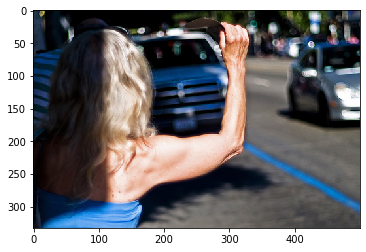

Caption: man with long hair and beard is standing next to woman in red shirt
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\106490881_5a2dd9b7bd.jpg


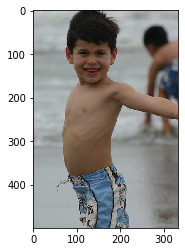

Caption: boy in swim trunks is jumping into the water
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1082379191_ec1e53f996.jpg


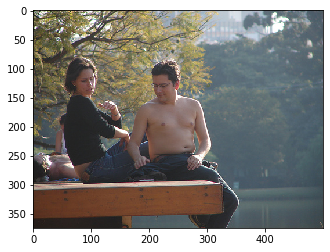

Caption: man in black shirt is sitting on bench
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1084040636_97d9633581.jpg


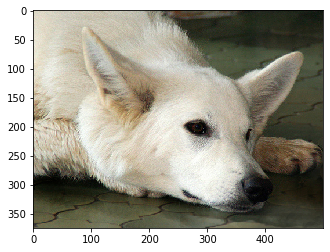

Caption: dog is running through the woods
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1096395242_fc69f0ae5a.jpg


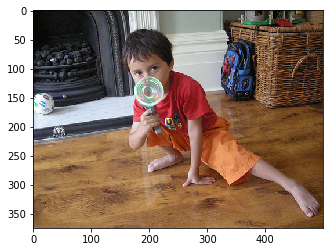

Caption: boy in blue shirt is laying on his head
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1107246521_d16a476380.jpg


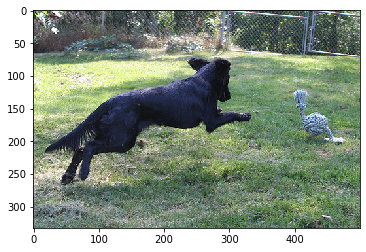

Caption: black dog is running through the grass
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1119015538_e8e796281e.jpg


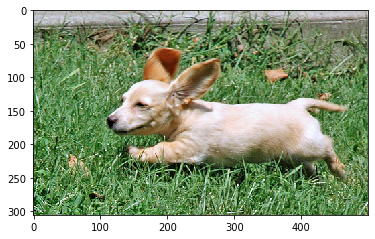

Caption: dog is running through the grass
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1122944218_8eb3607403.jpg


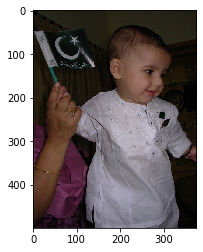

Caption: young boy with his arm around his face
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1131800850_89c7ffd477.jpg


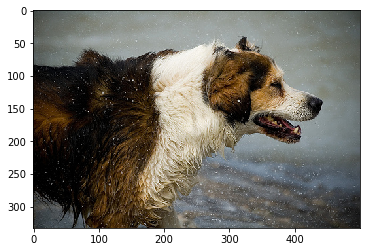

Caption: beagle is running through water
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1131932671_c8d17751b3.jpg


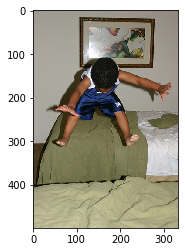

Caption: child is sitting on bed with his arms raised
_____________________________________


In [34]:
for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Images', pic))
  x=plt.imread(os.path.join(root_captioning,'Images', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [ ]:
caption_model.save_weights("test.hdf5")